## *Kaggle Survey Dataset* - by Pandata Pros CME538

In [87]:
# Configure Notebook
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import KNNImputer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency, pointbiserialr, ttest_ind, randint, uniform
from imblearn.pipeline import Pipeline

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [88]:
# Load the dataset
df = pd.read_csv("clean_kaggle_data_2022.csv", low_memory = False, encoding = 'latin2')

pd.set_option('display.max_columns', None)
df.head()

,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q8,Q9,Q10_1,Q10_2,Q10_3,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q19_1,Q19_2,Q19_3,Q19_4,Q19_5,Q19_6,Q19_7,Q19_8,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q20_6,Q21_1,Q21_2,Q21_3,Q21_4,Q21_5,Q21_6,Q21_7,Q21_8,Q21_9,Q21_10,Q22,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q29,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q32,Q33_1,Q33_2,Q33_3,Q33_4,Q33_5,Q34_1,Q34_2,Q34_3,Q34_4,Q34_5,Q34_6,Q34_7,Q34_8,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,"Are you currently a student? (high school, uni...",On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,On which platforms have you begun or completed...,What products or platforms did you find to be ...,What products or platforms did you find to be ...,What products or platforms did you find to be ...,What products or platforms did you find to be ...,What products or platforms did you find to be ...,What products or platforms did you find to be ...,What products or platforms did you find to be ...,What is the highest level of formal education ...,Have you ever published any academic research ...,Did your research make use of machine learning...,Did your research make use of machine learning...,Did your research make use of machine learning...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use 

In the "2022 Kaggle Machine Learning & Data Science Survey" dataset, the first row `(row[0])` contains the questions' short codes (like Q2, Q3, etc.), and the second row `(row[1])` often contains the full text of the questions. These rows serve as headers for the respondents' answers, which start from `row[2]` onward in the dataset.

For our data cleaning task, we want to use short, standard codes as our headers `(row[0])`. So, we would set our DataFrame headers to `row[0]` and then drop `row[1]` since it's redundant and could create confusion or errors during data manipulation. This keeps the dataset tidy and our column references clear.

However, before dropping row[1], it's a good idea to store the full question text elsewhere. This way, we can refer back to the full question text when we are interpreting our analysis.


In [89]:
# Extract the second row (full questions)
q_dict = df.iloc[0]

# Create a dictionary mapping column names to full questions
question_dict = dict(zip(df.columns, q_dict))

# Now we can access the full question for each column
print(question_dict['Q2'])  # "What is your age (# years)?"
print(question_dict['Q3'])  # "What is your gender?"

# After saving the full questions, we can drop the second row
df = df.drop(0) # Note the first row is not counted as it is set as a Header

# Rechecking the DataFrame structure
df.head()

What is your age (# years)?
What is your gender? - Selected Choice


,Duration (in seconds),Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q8,Q9,Q10_1,Q10_2,Q10_3,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q19_1,Q19_2,Q19_3,Q19_4,Q19_5,Q19_6,Q19_7,Q19_8,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q20_6,Q21_1,Q21_2,Q21_3,Q21_4,Q21_5,Q21_6,Q21_7,Q21_8,Q21_9,Q21_10,Q22,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q29,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q32,Q33_1,Q33_2,Q33_3,Q33_4,Q33_5,Q34_1,Q34_2,Q34_3,Q34_4,Q34_5,Q34_6,Q34_7,Q34_8,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
1,851,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,Udemy,NaN,NaN,NaN,NaN,Other,NaN,"Online courses (Coursera, EdX, etc)",NaN,NaN,"Kaggle (notebooks, competitions, etc)",NaN,NaN,Some college/university study without earning ...,NaN,NaN,NaN,NaN,10-20 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,NaN,Sublime Text,Vim / Emacs,NaN,Jupyter Notebook,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deepnote Notebooks,NaN,NaN,NaN,Matplotlib,Seaborn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-2 years,Scikit-learn,NaN,NaN,PyTorch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Huggingface,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transformer Networks (BERT, gpt-3, etc)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"Word embeddings/vectors (GLoVe, fastText, word...","Encoder-decoder models (seq2seq, vanilla trans...",NaN,"Transformer language models (GPT-3, BERT, XLne...",NaN,NaN,NaN,NaN,Huggingface Models,NaN,NaN,ONNX models,NaN,NaN,NaN,Other storage services (i.e. google drive),Huggingface Models,Data Scientist,Online Service/Internet-based Services,0-49 employees,2-Jan,"We recently started using ML methods (i.e., mo...",NaN,NaN,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,Experimentation and iteration to improve exist...,NaN,NaN,NaN,"25,000-29,999","$1000-$9,999",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MongoDB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No / None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No / None,NaN,NaN,NaN,ONNX Runtime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Weights & Biases,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,GPUs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-5 times,Twitter (data science influencers),NaN,NaN,"Kaggle (notebooks, forums, etc)","Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Sc

In [90]:
# Calculate the percentage of missing values for each column and display the full list of missing percentages
with pd.option_context('display.max_rows', None):
    print(df.isnull().mean() * 100)

Duration (in seconds)     0.000000
Q2                        0.000000
Q3                        0.000000
Q4                        0.000000
Q5                        0.000000
Q6_1                     53.761062
Q6_2                     86.258604
Q6_3                     70.747296
Q6_4                     82.091937
Q6_5                     94.186332
Q6_6                     88.421829
Q6_7                     71.029990
Q6_8                     87.315634
Q6_9                     90.855457
Q6_10                    76.511799
Q6_11                    90.105703
Q6_12                    76.745329
Q7_1                     74.606686
Q7_2                     36.996067
Q7_3                     86.320059
Q7_4                     47.566372
Q7_5                     44.505900
Q7_6                     96.632252
Q7_7                     90.240905
Q8                        0.000000
Q9                       36.147984
Q10_1                    91.592920
Q10_2                    84.132252
Q10_3               

**Visualizing missing data:** To visualize the missing data in our dataset, we can use a heatmap to give a quick overview of where the missing values are occurring:


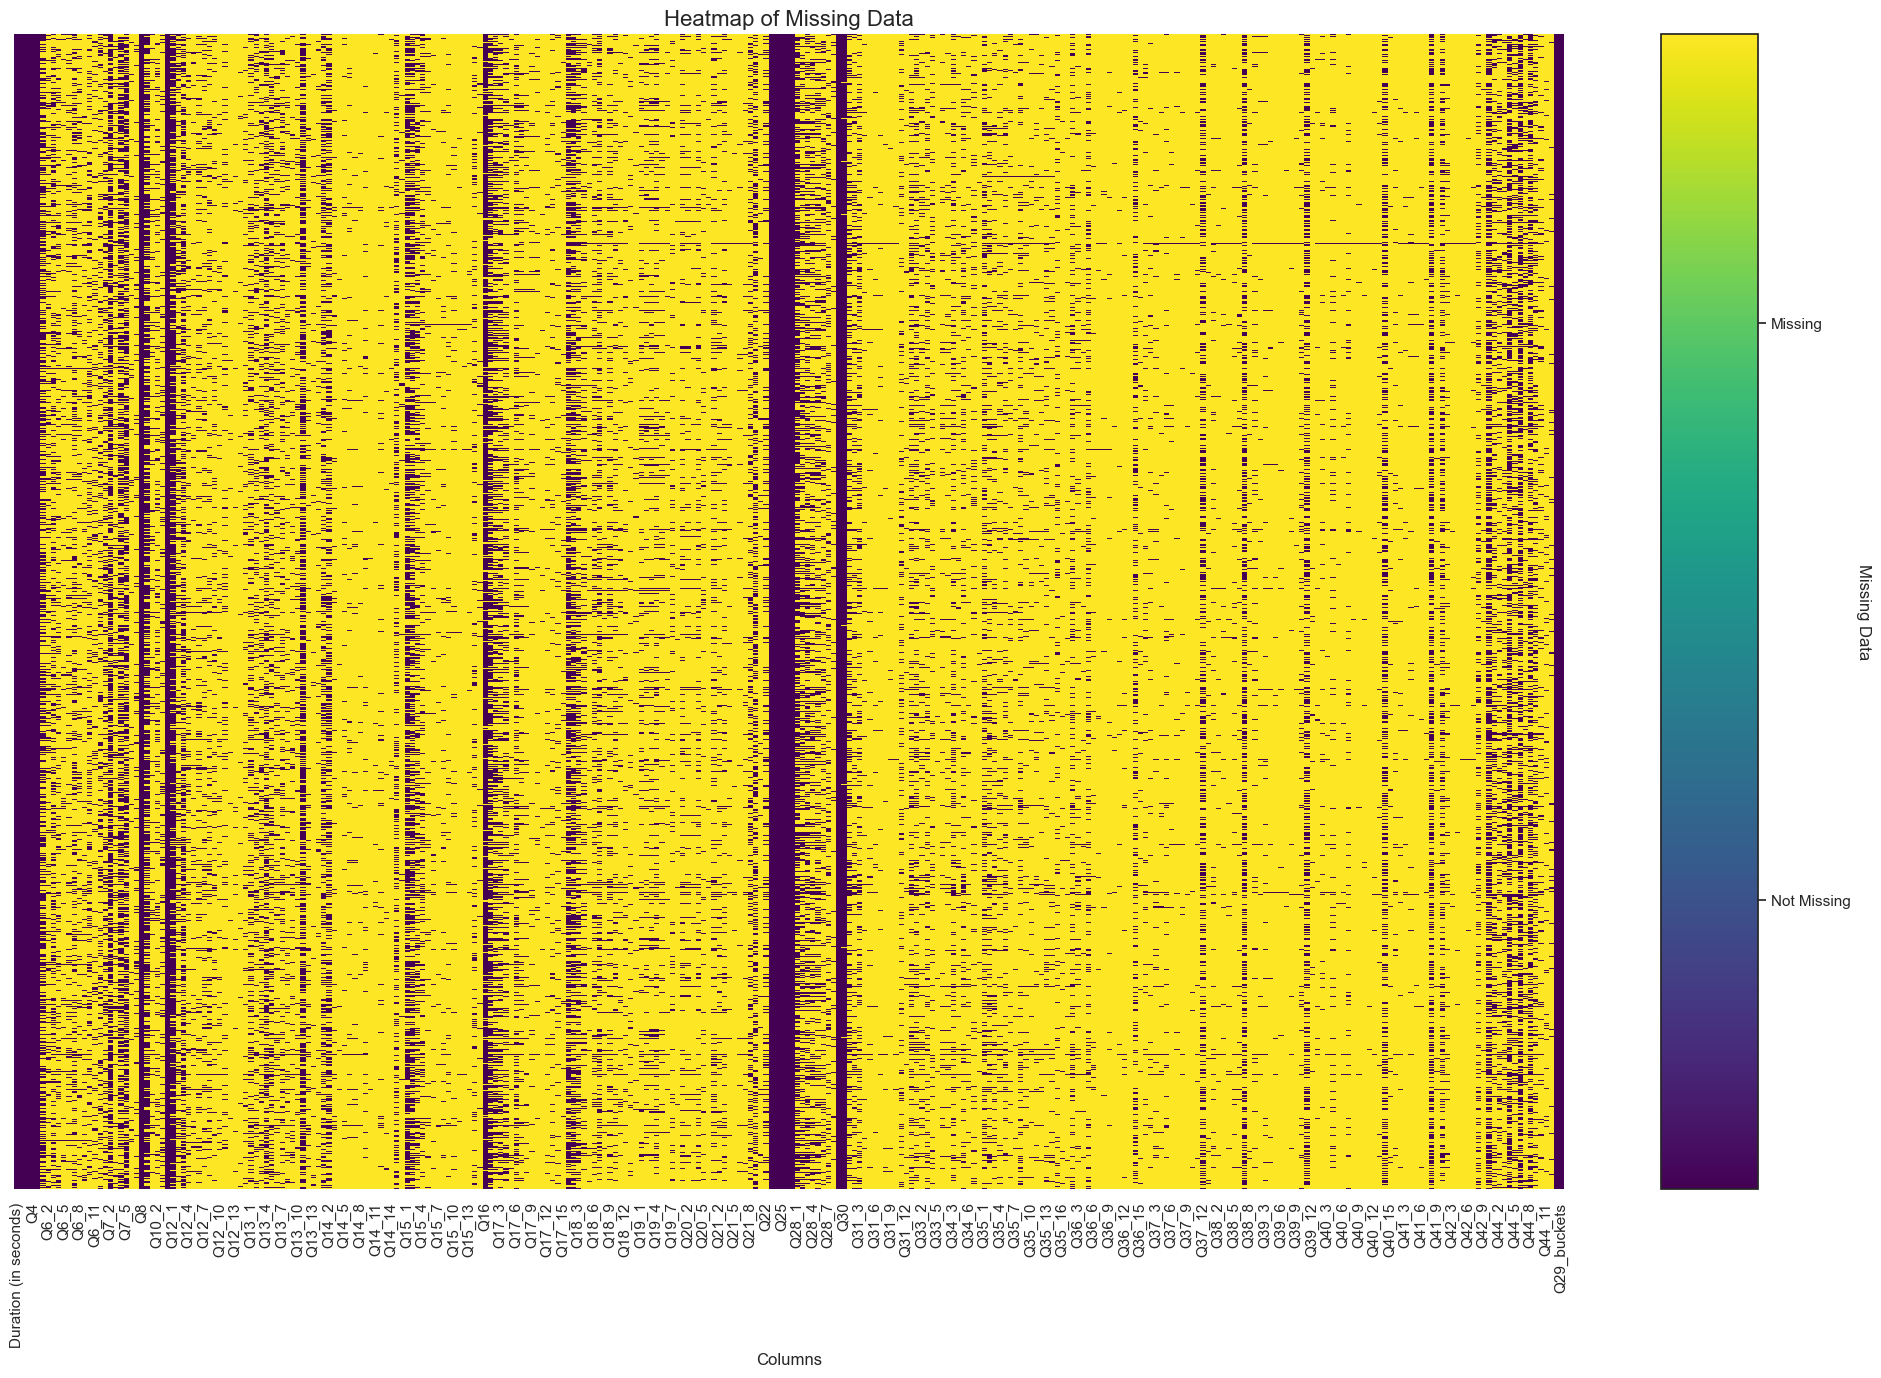

In [91]:
# Set the style of seaborn
sns.set(style="white")

# Calculate missing data
missing = df.isnull()

# Create a heatmap to visualize missing data
plt.figure(figsize=(25, 15))
sns.heatmap(missing, cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap of Missing Data', fontsize=16)
plt.xlabel('Columns', fontsize=12)

# Create a colorbar as a legend
colorbar = plt.colorbar(
    plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=1)),
    orientation='vertical',
    pad=0.05,
    aspect=12
)
colorbar.set_label('Missing Data', rotation=270, labelpad=15)
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Not Missing', 'Missing'])
plt.show()

From the heatmap, we observe substantial gaps indicating missing values. Our strategy will involve a careful balance between retaining information and maintaining a robust dataset for analysis. Our objective is to predict the salary buckets of respondents. Columns with a high percentage of missing values might need to be dropped or imputed thoughtfully without causing any information loss that would bias our predictions on a salary bucket of a participant from the test dataset.


- Duration isn't relevant, so we'll drop it:

In [92]:
df.drop("Duration (in seconds)", axis = 1, inplace = True)

- Handling some text issues for Q8:

In [93]:
# Check the unique values and their frequencies for Q8 (Education Level)
print(df['Q8'].value_counts())

MasterEEs degree                                                      3567
BachelorEEs degree                                                    2005
Doctoral degree                                                          1349
I prefer not to answer                                                    426
Some college/university study without earning a bachelorEEs degree     304
Professional doctorate                                                    279
No formal education past high school                                      206
Name: Q8, dtype: int64


In [94]:
# Correcting character issues in 'Q8' column using conditional replacement
df['Q8'] = df['Q8'].apply(lambda x: "Masters degree" if 'Master' in x else x)
df['Q8'] = df['Q8'].apply(lambda x: "Bachelors degree" if 'Bachelor' in x else x)
df['Q8'] = df['Q8'].apply(lambda x: "Some college/university study without earning a bachelors degree" if 'Some college' in x else x)

# Verifying the corrections
print(df['Q8'].value_counts())

Masters degree                                                      3567
Bachelors degree                                                    2005
Doctoral degree                                                     1349
I prefer not to answer                                               426
Some college/university study without earning a bachelors degree     304
Professional doctorate                                               279
No formal education past high school                                 206
Name: Q8, dtype: int64


In [95]:
df.head()

,Q2,Q3,Q4,Q5,Q6_1,Q6_2,Q6_3,Q6_4,Q6_5,Q6_6,Q6_7,Q6_8,Q6_9,Q6_10,Q6_11,Q6_12,Q7_1,Q7_2,Q7_3,Q7_4,Q7_5,Q7_6,Q7_7,Q8,Q9,Q10_1,Q10_2,Q10_3,Q11,Q12_1,Q12_2,Q12_3,Q12_4,Q12_5,Q12_6,Q12_7,Q12_8,Q12_9,Q12_10,Q12_11,Q12_12,Q12_13,Q12_14,Q12_15,Q13_1,Q13_2,Q13_3,Q13_4,Q13_5,Q13_6,Q13_7,Q13_8,Q13_9,Q13_10,Q13_11,Q13_12,Q13_13,Q13_14,Q14_1,Q14_2,Q14_3,Q14_4,Q14_5,Q14_6,Q14_7,Q14_8,Q14_9,Q14_10,Q14_11,Q14_12,Q14_13,Q14_14,Q14_15,Q14_16,Q15_1,Q15_2,Q15_3,Q15_4,Q15_5,Q15_6,Q15_7,Q15_8,Q15_9,Q15_10,Q15_11,Q15_12,Q15_13,Q15_14,Q15_15,Q16,Q17_1,Q17_2,Q17_3,Q17_4,Q17_5,Q17_6,Q17_7,Q17_8,Q17_9,Q17_10,Q17_11,Q17_12,Q17_13,Q17_14,Q17_15,Q18_1,Q18_2,Q18_3,Q18_4,Q18_5,Q18_6,Q18_7,Q18_8,Q18_9,Q18_10,Q18_11,Q18_12,Q18_13,Q18_14,Q19_1,Q19_2,Q19_3,Q19_4,Q19_5,Q19_6,Q19_7,Q19_8,Q20_1,Q20_2,Q20_3,Q20_4,Q20_5,Q20_6,Q21_1,Q21_2,Q21_3,Q21_4,Q21_5,Q21_6,Q21_7,Q21_8,Q21_9,Q21_10,Q22,Q23,Q24,Q25,Q26,Q27,Q28_1,Q28_2,Q28_3,Q28_4,Q28_5,Q28_6,Q28_7,Q28_8,Q29,Q30,Q31_1,Q31_2,Q31_3,Q31_4,Q31_5,Q31_6,Q31_7,Q31_8,Q31_9,Q31_10,Q31_11,Q31_12,Q32,Q33_1,Q33_2,Q33_3,Q33_4,Q33_5,Q34_1,Q34_2,Q34_3,Q34_4,Q34_5,Q34_6,Q34_7,Q34_8,Q35_1,Q35_2,Q35_3,Q35_4,Q35_5,Q35_6,Q35_7,Q35_8,Q35_9,Q35_10,Q35_11,Q35_12,Q35_13,Q35_14,Q35_15,Q35_16,Q36_1,Q36_2,Q36_3,Q36_4,Q36_5,Q36_6,Q36_7,Q36_8,Q36_9,Q36_10,Q36_11,Q36_12,Q36_13,Q36_14,Q36_15,Q37_1,Q37_2,Q37_3,Q37_4,Q37_5,Q37_6,Q37_7,Q37_8,Q37_9,Q37_10,Q37_11,Q37_12,Q37_13,Q38_1,Q38_2,Q38_3,Q38_4,Q38_5,Q38_6,Q38_7,Q38_8,Q39_1,Q39_2,Q39_3,Q39_4,Q39_5,Q39_6,Q39_7,Q39_8,Q39_9,Q39_10,Q39_11,Q39_12,Q40_1,Q40_2,Q40_3,Q40_4,Q40_5,Q40_6,Q40_7,Q40_8,Q40_9,Q40_10,Q40_11,Q40_12,Q40_13,Q40_14,Q40_15,Q41_1,Q41_2,Q41_3,Q41_4,Q41_5,Q41_6,Q41_7,Q41_8,Q41_9,Q42_1,Q42_2,Q42_3,Q42_4,Q42_5,Q42_6,Q42_7,Q42_8,Q42_9,Q43,Q44_1,Q44_2,Q44_3,Q44_4,Q44_5,Q44_6,Q44_7,Q44_8,Q44_9,Q44_10,Q44_11,Q44_12,Q29_Encoded,Q29_buckets
1,55-59,Man,France,No,Coursera,NaN,Kaggle Learn Courses,NaN,NaN,NaN,Udemy,NaN,NaN,NaN,NaN,Other,NaN,"Online courses (Coursera, EdX, etc)",NaN,NaN,"Kaggle (notebooks, competitions, etc)",NaN,NaN,Some college/university study without earning ...,NaN,NaN,NaN,NaN,10-20 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,NaN,Sublime Text,Vim / Emacs,NaN,Jupyter Notebook,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deepnote Notebooks,NaN,NaN,NaN,Matplotlib,Seaborn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1-2 years,Scikit-learn,NaN,NaN,PyTorch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Huggingface,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transformer Networks (BERT, gpt-3, etc)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,"Word embeddings/vectors (GLoVe, fastText, word...","Encoder-decoder models (seq2seq, vanilla trans...",NaN,"Transformer language models (GPT-3, BERT, XLne...",NaN,NaN,NaN,NaN,Huggingface Models,NaN,NaN,ONNX models,NaN,NaN,NaN,Other storage services (i.e. google drive),Huggingface Models,Data Scientist,Online Service/Internet-based Services,0-49 employees,2-Jan,"We recently started using ML methods (i.e., mo...",NaN,NaN,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,Experimentation and iteration to improve exist...,NaN,NaN,NaN,"25,000-29,999","$1000-$9,999",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MongoDB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No / None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No / None,NaN,NaN,NaN,ONNX Runtime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Weights & Biases,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,GPUs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-5 times,Twitter (data science influencers),NaN,NaN,"Kaggle (notebooks, forums, etc)","Course Forums (forums.fast.ai, Coursera forums...",NaN,NaN,"Blogs (Towards Data Science, Analytics Vidhya,..

- Handling `Q2`: Age

In [96]:
df['Q2'].value_counts()

25-29    1604
30-34    1430
35-39    1207
40-44    1037
22-24     743
45-49     701
50-54     567
55-59     359
60-69     341
18-21      83
70+        64
Name: Q2, dtype: int64

In [97]:
def convert_age_range(age_range):
    if '-' in age_range:
        lower, upper = map(int, age_range.split('-'))
        return (lower + upper) / 2
    elif age_range == '70+':
        return 70
    return age_range

# Apply the function to the age column
df['Q2'] = df['Q2'].apply(convert_age_range)

In [98]:
df['Q2'].value_counts()

27.0    1604
32.0    1430
37.0    1207
42.0    1037
23.0     743
47.0     701
52.0     567
57.0     359
64.5     341
19.5      83
70.0      64
Name: Q2, dtype: int64

- Handling `Q5` - Student or not?:

In [99]:
df['Q5'].value_counts()

No    8136
Name: Q5, dtype: int64

Since we only have Non-students filling out the survey - `(Q5)` doesn't provide any useful information for modeling because it doesn't vary across the dataset. In such cases, it's a good idea to drop the feature because it won't contribute to the model's ability to make predictions.

In [100]:
df = df.drop("Q5", axis=1)

- Handling `Q9` - Whether they published a paper or no?:

In [101]:
df['Q9'].value_counts()

Yes    2672
No     2523
Name: Q9, dtype: int64

In [102]:
df['Q9'] = df['Q9'].map({'Yes': 1, 'No': 0})

In [103]:
df['Q9'].value_counts()

1.0    2672
0.0    2523
Name: Q9, dtype: int64

- Handlin errors in `Q26` - # Individuals are responsible for data science workloads:

In [104]:
df['Q26'].value_counts()

20+       2061
2-Jan     1658
0         1298
4-Mar     1257
9-May     1029
14-Oct     595
15-19      238
Name: Q26, dtype: int64

In [105]:
# Correction for mislabeled data in Q26
df['Q26'] = df['Q26'].replace({'2-Jan': '1-2', '4-Mar': '3-4', '9-May': '5-9', '14-Oct': '10-14'})

In [106]:
df['Q26'].value_counts()

20+      2061
1-2      1658
0        1298
3-4      1257
5-9      1029
10-14     595
15-19     238
Name: Q26, dtype: int64

- `Q29` - Salary: will ve dropped as we earlier processed them in `KaggleSalary_DataSet.ipynb`

In [107]:
df.drop("Q29", axis = 1, inplace = True)

In [108]:
df.drop('Q29_buckets', axis = 1, inplace = True)

- `Q22` and `Q32` are single choice questions and they have more than 80% NaNs, so we'll drop them:

In [109]:
df.drop('Q22', axis = 1, inplace = True)

In [110]:
df.drop('Q32', axis = 1, inplace = True)

---

In [111]:
# Initialize an empty list for one-hot encoded columns
one_hot_cols = []

# Questions 6, 7, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 28, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42
# represent multiple-choice questions where respondents can select multiple options.
# These are suitable for one-hot encoding.
# Comprehensive list of multi-choice questions with their respective number of options
multi_choice_questions = [
    {'q_num': 6, 'options': 12},  # Learning platforms used
    {'q_num': 7, 'options': 7},   # Primary tool for analyzing data
    {'q_num': 10, 'options': 3},  # Type of conducted research
    {'q_num': 12, 'options': 15}, # Programming languages used
    {'q_num': 13, 'options': 14}, # Integrated development environments (IDEs) used
    {'q_num': 14, 'options': 16}, # Hosted notebook products used
    {'q_num': 15, 'options': 15}, # Visualization libraries used
    {'q_num': 17, 'options': 15}, # Machine Learning frameworks used
    {'q_num': 18, 'options': 14}, # Machine Learning algorithms used
    {'q_num': 19, 'options': 8},  # Computer Vision methods used
    {'q_num': 20, 'options': 6},  # Natural Language Processing (NLP) methods used
    {'q_num': 21, 'options': 10}, # Pre-trained model weights download services used
    {'q_num': 28, 'options': 8},  # Activities that make up an important part of role at work
    {'q_num': 31, 'options': 12}, # Cloud computing platforms used
    {'q_num': 33, 'options': 5},  # Cloud computing products used
    {'q_num': 34, 'options': 8},  # Data storage products used
    {'q_num': 35, 'options': 16}, # Data products (relational databases, data warehouses, etc.) used
    {'q_num': 36, 'options': 15}, # Business intelligence tools used
    {'q_num': 37, 'options': 13}, # Managed machine learning products used
    {'q_num': 38, 'options': 8},  # Automated machine learning tools used
    {'q_num': 39, 'options': 12}, # Products to serve machine learning models used
    {'q_num': 40, 'options': 15}, # Tools to help monitor machine learning models/experiments used
    {'q_num': 41, 'options': 9},  # Responsible or ethical AI products used
    {'q_num': 42, 'options': 9},  # Specialized hardware used for training machine learning models
    {'q_num': 44, 'options': 12}, # Favorite data science media sources
]

# Loop through each multi-choice question and generate column names
for q in multi_choice_questions:
    for opt in range(1, q['options'] + 1):
        col_name = f"Q{q['q_num']}_{opt}"
        one_hot_cols.append(col_name)

# Add other one-hot encoded columns
additional_one_hot_cols = [
    'Q3',  # Gender
    'Q4',  # Country of residence
    'Q23', # Current role title
    'Q24', # Industry category
]

# Extend the one-hot columns list with additional columns
one_hot_cols.extend(additional_one_hot_cols)

# Print the final list of one-hot encoded columns
print("One-hot encoded columns:", one_hot_cols)

One-hot encoded columns: ['Q6_1', 'Q6_2', 'Q6_3', 'Q6_4', 'Q6_5', 'Q6_6', 'Q6_7', 'Q6_8', 'Q6_9', 'Q6_10', 'Q6_11', 'Q6_12', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q7_7', 'Q10_1', 'Q10_2', 'Q10_3', 'Q12_1', 'Q12_2', 'Q12_3', 'Q12_4', 'Q12_5', 'Q12_6', 'Q12_7', 'Q12_8', 'Q12_9', 'Q12_10', 'Q12_11', 'Q12_12', 'Q12_13', 'Q12_14', 'Q12_15', 'Q13_1', 'Q13_2', 'Q13_3', 'Q13_4', 'Q13_5', 'Q13_6', 'Q13_7', 'Q13_8', 'Q13_9', 'Q13_10', 'Q13_11', 'Q13_12', 'Q13_13', 'Q13_14', 'Q14_1', 'Q14_2', 'Q14_3', 'Q14_4', 'Q14_5', 'Q14_6', 'Q14_7', 'Q14_8', 'Q14_9', 'Q14_10', 'Q14_11', 'Q14_12', 'Q14_13', 'Q14_14', 'Q14_15', 'Q14_16', 'Q15_1', 'Q15_2', 'Q15_3', 'Q15_4', 'Q15_5', 'Q15_6', 'Q15_7', 'Q15_8', 'Q15_9', 'Q15_10', 'Q15_11', 'Q15_12', 'Q15_13', 'Q15_14', 'Q15_15', 'Q17_1', 'Q17_2', 'Q17_3', 'Q17_4', 'Q17_5', 'Q17_6', 'Q17_7', 'Q17_8', 'Q17_9', 'Q17_10', 'Q17_11', 'Q17_12', 'Q17_13', 'Q17_14', 'Q17_15', 'Q18_1', 'Q18_2', 'Q18_3', 'Q18_4', 'Q18_5', 'Q18_6', 'Q18_7', 'Q18_8', 'Q18_9', 'Q18_1

In [112]:
ordinal_cols_and_order = {
    'Q8': ['No formal education past high school', 'Some college/university study without earning a bachelors degree', 'Bachelors degree', 'Masters degree', 'Doctoral degree', 'Professional doctorate', 'I prefer not to answer'],
    'Q11': ['I have never written code', '< 1 years', '1-3 years', '3-5 years', '5-10 years', '10-20 years', '20+ years'],
    'Q16': ['I do not use machine learning methods', 'Under 1 year', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-20 years'],
    'Q25': ['0-49 employees', '50-249 employees', '250-999 employees', '1000-9,999 employees', '10,000 or more employees'],
    'Q26': ['0', '1-2', '3-4', '5-9', '10-14', '15-19', '20+'],
    'Q27': [ "No (we do not use ML methods)", "I do not know",
    "We have well established ML methods (i.e., models in production for more than 2 years)",
    "We are exploring ML methods (and may one day put a model into production)",
    "We recently started using ML methods (i.e., models in production for less than 2 years)",
    "We use ML methods for generating insights (but do not put working models into production)"],
    'Q30': ['$0 ($USD)', '$1-$99', '$100-$999', '$1000-$9,999', '$10,000-$99,999', '$100,000 or more ($USD)'],
    'Q43': ['Never', 'Once', '2-5 times', '6-25 times', 'More than 25 times']
}

In [113]:
numerical_cols = ['Q2'] # Age, after converting ranges to midpoints

---

To prepare our dataset for a neural network, we will need to process our data appropriately based on the types of variables we have: one-hot encoded columns, ordinal columns, and numerical columns. Let's break down the steps:

### 1. Handling Missing Values:

For columns that have NaNs, especially in the case of multiple-choice questions where an entire set of related columns might be blank, we will replace NaNs with a constant value (like 0 or -1).

In [114]:
# Step 1: Handling Missing Values (Example using constant -1)
df.fillna(-1, inplace=True)

### 2. One-Hot Encoding
One-hot encoding converts categorical data into a format that's easier for neural networks to understand. Each category value is converted into a new column and assigned a 1 or 0 (notation for true/false) in those columns.

In [115]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

# Step 2: One-Hot Encoding
df = pd.get_dummies(df, columns=one_hot_cols)

### 3. Ordinal Encoding
Ordinal variables are categorical variables that have a defined order. We'll need to map these to numeric values while preserving the order. Each column in `ordinal_cols_and_order` needs its own set of categories for encoding.

In [116]:
# Step 3: Ordinal Encoding
ordinal_cols_and_order_modified = {
    col: ['-1'] + categories for col, categories in ordinal_cols_and_order.items()
}

# Encoding with modified categories
for col, categories in ordinal_cols_and_order_modified.items():
    ordinal_encoder = OrdinalEncoder(categories=[categories])
    df[col] = ordinal_encoder.fit_transform(df[[col]].astype(str))

### 4. Handling Numerical Columns
Numerical columns should be normalized for neural networks. This involves scaling the data to have a mean of 0 and a standard deviation of 1.

In [117]:
# Step 4: Normalizing Numerical Columns
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

The dataset is now ready for training a neural network

In [118]:
df.head()

,Q2,Q8,Q9,Q11,Q16,Q25,Q26,Q27,Q30,Q43,Q29_Encoded,Q6_1_-1,Q6_1_Coursera,Q6_2_-1,Q6_2_edX,Q6_3_-1,Q6_3_Kaggle Learn Courses,Q6_4_-1,Q6_4_DataCamp,Q6_5_-1,Q6_5_Fast.ai,Q6_6_-1,Q6_6_Udacity,Q6_7_-1,Q6_7_Udemy,Q6_8_-1,Q6_8_LinkedIn Learning,Q6_9_-1,"Q6_9_Cloud-certification programs (direct from AWS, Azure, GCP, or similar)",Q6_10_-1,Q6_10_University Courses (resulting in a university degree),Q6_11_-1,Q6_11_None,Q6_12_-1,Q6_12_Other,Q7_1_-1,Q7_1_University courses,Q7_2_-1,"Q7_2_Online courses (Coursera, EdX, etc)",Q7_3_-1,"Q7_3_Social media platforms (Reddit, Twitter, etc)",Q7_4_-1,"Q7_4_Video platforms (YouTube, Twitch, etc)",Q7_5_-1,"Q7_5_Kaggle (notebooks, competitions, etc)",Q7_6_-1,Q7_6_None / I do not study data science,Q7_7_-1,Q7_7_Other,Q10_1_-1,"Q10_1_Yes, the research made advances related to some novel machine learning method (theoretical research)",Q10_2_-1,"Q10_2_Yes, the research made use of machine learning as a tool (applied research)",Q10_3_-1,Q10_3_No,Q12_1_-1,Q12_1_Python,Q12_2_-1,Q12_2_R,Q12_3_-1,Q12_3_SQL,Q12_4_-1,Q12_4_C,Q12_5_-1,Q12_5_C#,Q12_6_-1,Q12_6_C++,Q12_7_-1,Q12_7_Java,Q12_8_-1,Q12_8_Javascript,Q12_9_-1,Q12_9_Bash,Q12_10_-1,Q12_10_PHP,Q12_11_-1,Q12_11_MATLAB,Q12_12_-1,Q12_12_Julia,Q12_13_-1,Q12_13_Go,Q12_14_-1,Q12_14_None,Q12_15_-1,Q12_15_Other,Q13_1_-1,Q13_1_JupyterLab,Q13_2_-1,Q13_2_ RStudio,Q13_3_-1,Q13_3_ Visual Studio,Q13_4_-1,Q13_4_ Visual Studio Code (VSCode),Q13_5_-1,Q13_5_ PyCharm,Q13_6_-1,Q13_6_ Spyder,Q13_7_-1,Q13_7_ Notepad++,Q13_8_-1,Q13_8_ Sublime Text,Q13_9_-1,Q13_9_ Vim / Emacs,Q13_10_-1,Q13_10_ MATLAB,Q13_11_-1,Q13_11_ Jupyter Notebook,Q13_12_-1,Q13_12_IntelliJ,Q13_13_-1,Q13_13_None,Q13_14_-1,Q13_14_Other,Q14_1_-1,Q14_1_ Kaggle Notebooks,Q14_2_-1,Q14_2_Colab Notebooks,Q14_3_-1,Q14_3_Azure Notebooks,Q14_4_-1,Q14_4_ Code Ocean,Q14_5_-1,Q14_5_ IBM Watson Studio,Q14_6_-1,Q14_6_ Amazon Sagemaker Studio,Q14_7_-1,Q14_7_ Amazon Sagemaker Studio Lab,Q14_8_-1,Q14_8_ Amazon EMR Notebooks,Q14_9_-1,Q14_9_Google Cloud Vertex AI Workbench,Q14_10_-1,Q14_10_Hex Workspaces,Q14_11_-1,Q14_11_ Noteable Notebooks,Q14_12_-1,Q14_12_ Databricks Collaborative Notebooks,Q14_13_-1,Q14_13_ Deepnote Notebooks,Q14_14_-1,Q14_14_ Gradient Notebooks,Q14_15_-1,Q14_15_None,Q14_16_-1,Q14_16_Other,Q15_1_-1,Q15_1_ Matplotlib,Q15_2_-1,Q15_2_ Seaborn,Q15_3_-1,Q15_3_ Plotly / Plotly Express,Q15_4_-1,Q15_4_ Ggplot / ggplot2,Q15_5_-1,Q15_5_ Shiny,Q15_6_-1,Q15_6_ D3 js,Q15_7_-1,Q15_7_ Altair,Q15_8_-1,Q15_8_ Bokeh,Q15_9_-1,Q15_9_ Geoplotlib,Q15_10_-1,Q15_10_ Leaflet / Folium,Q15_11_-1,Q15_11_ Pygal,Q15_12_-1,Q15_12_ Dygraphs,Q15_13_-1,Q15_13_ Highcharter,Q15_14_-1,Q15_14_None,Q15_15_-1,Q15_15_Other,Q17_1_-1,Q17_1_ Scikit-learn,Q17_2_-1,Q17_2_ TensorFlow,Q17_3_-1,Q17_3_ Keras,Q17_4_-1,Q17_4_ PyTorch,Q17_5_-1,Q17_5_ Fast.ai,Q17_6_-1,Q17_6_ Xgboost,Q17_7_-1,Q17_7_ LightGBM,Q17_8_-1,Q17_8_ CatBoost,Q17_9_-1,Q17_9_ Caret,Q17_10_-1,Q17_10_ Tidymodels,Q17_11_-1,Q17_11_ JAX,Q17_12_-1,Q17_12_ PyTorch Lightning,Q17_13_-1,Q17_13_ Huggingface,Q17_14_-1,Q17_14_None,Q17_15_-1,Q17_15_Other,Q18_1_-1,Q18_1_Linear or Logistic Regression,Q18_2_-1,Q18_2_Decision Trees or Random Forests,Q18_3_-1,"Q18_3_Gradient Boosting Machines (xgboost, lightgbm, etc)",Q18_4_-1,Q18_4_Bayesian Approaches,Q18_5_-1,Q18_5_Evolutionary Approaches,Q18_6_-1,"Q18_6_Dense Neural Networks (MLPs, etc)",Q18_7_-1,Q18_7_Convolutional Neural Networks,Q18_8_-1,Q18_8_Generative Adversarial Networks,Q18_9_-1,Q18_9_Recurrent Neural Networks,Q18_10_-1,"Q18_10_Transformer Networks (BERT, gpt-3, etc)",Q18_11_-1,"Q18_11_Autoencoder Networks (DAE, VAE, etc)",Q18_12_-1,Q18_12_Graph Neural Networks,Q18_13_-1,Q18_13_None,Q18_14_-1,Q18_14_Other,Q19_1_-1,"Q19_1_General purpose image/video tools (PIL, cv2, skimage, etc)",Q19_2_-1,"Q19_2_Image segmentation methods (U-Net, Mask R-CNN, etc)",Q19_3_-1,"Q19_3_Object detection methods (YOLOv6, RetinaNet, etc)",Q19_4_-1,"Q19_4_Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)",Q19_5_-1

In [119]:
# Check data types
print(df.dtypes)

# Convert 'Q29_Encoded' to int as it's a classification problem
df['Q29_Encoded'] = df['Q29_Encoded'].astype(int)

Q2                                            float64
Q8                                            float64
Q9                                            float64
Q11                                           float64
Q16                                           float64
                                               ...   
Q24_Non-profit/Service                          uint8
Q24_Online Service/Internet-based Services      uint8
Q24_Other                                       uint8
Q24_Retail/Sales                                uint8
Q24_Shipping/Transportation                     uint8
Length: 657, dtype: object


---

In [120]:
!pip install tensorflow

In [121]:
!pip install keras

##**Feature Selection and Model Training**

In this section, we will focus on selecting features that are highly correlated with our target variable, `Q29_Encoded`, which represents 15 distinct salary buckets. The objective is to identify features that have a strong linear relationship with the target variable, thereby providing a solid foundation for our neural network model.

### **Correlation Analysis**

We start by calculating the correlation coefficients between all features and the target variable:


In [122]:
# Calculate correlations
correlation_matrix = df.corr()

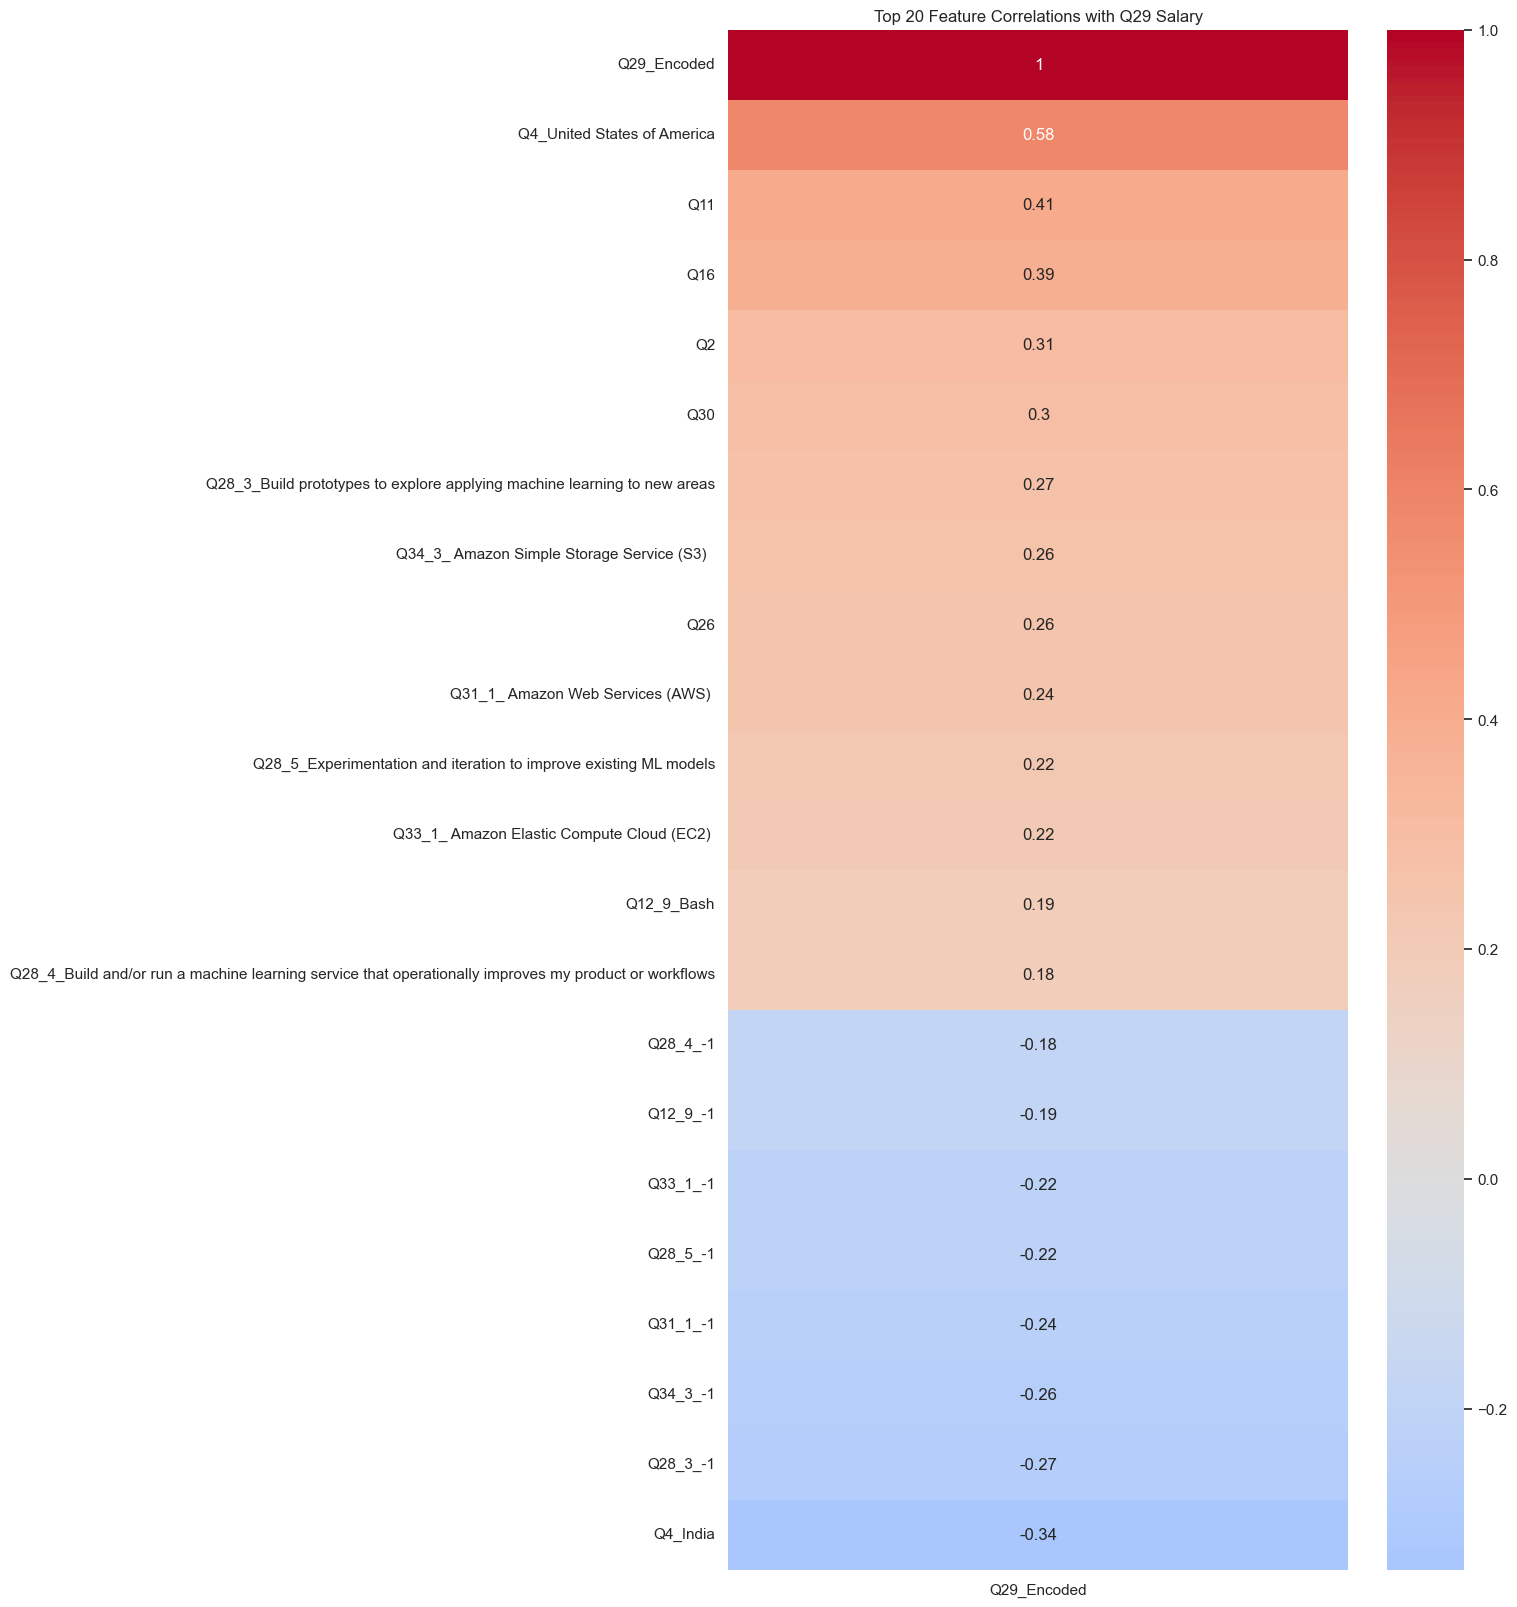

In [123]:
# Get the correlations with the target variable 'Q29 buckets'
target_correlation = correlation_matrix['Q29_Encoded']

# Select the top 20 features excluding the target itself
top_20_features = target_correlation.abs().sort_values(ascending=False)[0:22].index

# Create a DataFrame with the top 20 features
df_top_20 = df[top_20_features]

# Recalculate the correlation matrix for the top 20 features
correlation_matrix_top_20 = df_top_20.corr()

# Visualizing the correlations of the top 20 features with the target
plt.figure(figsize=(10, 20))
sns.heatmap(correlation_matrix_top_20[['Q29_Encoded']].sort_values(by='Q29_Encoded', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title('Top 20 Feature Correlations with Q29 Salary')
plt.show()

Using these coefficients, we identify features that have a correlation above a certain threshold with the target variable. This threshold is set to 0.1 in absolute value, meaning we are interested in features that have at least a moderate linear relationship with the target:

In [124]:
# Selecting features with high correlation to the target variable
high_corr_features = correlation_matrix['Q29_Encoded'][abs(correlation_matrix['Q29_Encoded']) > 0.1].index.tolist()

In [125]:
high_corr_features.remove('Q29_Encoded')

Some features repeatedly come from the same question, we will filter out the question number only

In [126]:
# Regular expression to match the pattern 'Q' followed by digits
pattern = r'Q\d+'

# Extract the pattern and remove duplicates using a set
extracted = set(re.match(pattern, index).group() for index in high_corr_features if re.match(pattern, index))

# Convert the set back to a list
unique_extracted = list(extracted)

# Output the result
print(f'The top 20 questions with the highest correlation are: ',unique_extracted)

The top 20 questions with the highest correlation are:  ['Q10', 'Q2', 'Q11', 'Q25', 'Q4', 'Q13', 'Q21', 'Q23', 'Q39', 'Q14', 'Q30', 'Q40', 'Q7', 'Q9', 'Q31', 'Q27', 'Q34', 'Q20', 'Q18', 'Q36', 'Q6', 'Q37', 'Q19', 'Q43', 'Q12', 'Q24', 'Q44', 'Q17', 'Q28', 'Q16', 'Q38', 'Q33', 'Q41', 'Q26', 'Q42', 'Q35', 'Q15']


In [127]:
print(f'Number of factors that contribute to the salary bucket that we can further investigate: ' + str(len(unique_extracted)))

Number of factors that contribute to the salary bucket that we can further investigate: 37


## Exploratory Data Analysis & Feature Selection

### Salary Distribution among all survey respondants

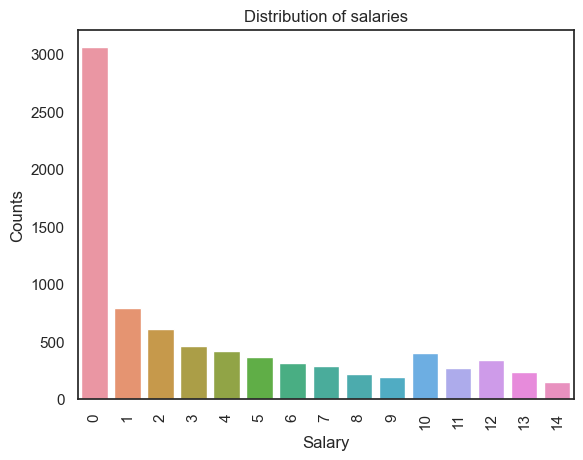

In [128]:
# Count the number of unique values
value_counts = df['Q29_Encoded'].value_counts()

# Reset index to make 'column_name' a column (not an index)
value_counts = value_counts.reset_index()
value_counts.columns = ['unique_value', 'counts']  # Renaming columns for clarity

# Plotting the result
sns.barplot(x='unique_value', y='counts', data=value_counts)
plt.xlabel('Salary')
plt.ylabel('Counts')
plt.xticks(rotation=90)  # Rotate x-labels for better readability
plt.title('Distribution of salaries')
plt.show()

The chart shows that most people earn between 0 and 15,000, making it the most common salary range. As the salary buckets increase, the counts decrease, showing a right-skewed distribution which suggests that higher salaries are less common among the surveyed group. 

### What are respondents' country of residence?

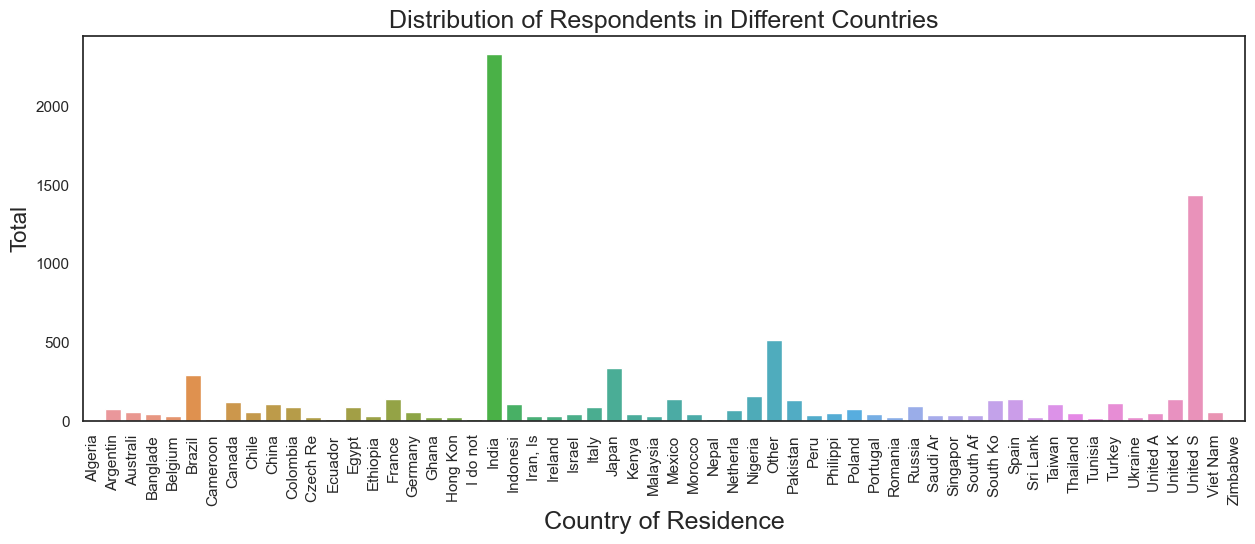

In [129]:
# Filter out columns starting with 'Q4'
q4_columns = df.filter(regex='^Q4_').columns

# Create shortened labels by taking the first 2 letters of the country name
short_labels = [label.split('_')[1][:8] for label in q4_columns]

# Calculate the sum for each column
column_sums = df[q4_columns].sum()

# Plotting
plt.figure(figsize=(15, 5))  # Adjust the size as needed
sns.barplot(x=short_labels, y=column_sums.values)
plt.title('Distribution of Respondents in Different Countries', fontsize=18)
plt.xticks(rotation=90)  # Rotate x-labels for better readability
plt.xlabel('Country of Residence', fontsize=18)
plt.ylabel('Total', fontsize=16)
plt.show()

The bar chart displays the distribution of survey respondents across various countries. A notable observation is that most of the survey respondents come from the US and India. The majority of countries have a relatively low count of respondents in comparison.

## Analyzing the features using statistical tests:
### - T-Test Results:
- Compares the means between each feature and the target variable. It's appropriate for features that are continuous or ordinal.
- Features with a T-Test P-value less than 0.05 indicate a statistically significant difference in means between the groups defined by the target variable.
### - Chi-Square Test Results:
- Assesses the association between each binned feature and the categorical target variable. This is typically used for categorical features, but the code bins continuous or ordinal features to apply this test.
- A Chi-Square P-value less than 0.05 suggests a significant association between the feature and the target variable. The sorted DataFrame helps in quickly identifying features with weaker associations (higher P-values).
### - Point-Biserial Correlation Results: 
- Measures the correlation between each feature (as continuous) and the binary target variable. This is specifically for scenarios where one variable is continuous and the other is binary.
- Features with a Point-Biserial P-value less than 0.05 indicate a significant linear correlation between the feature and the target variable.

## Defining helper functions
The intent is to provide functions that can be used to analyze the relationship between continuous and categorical variables within a dataset.

The bin_data function below is intended to preprocess continuous data so that it can be used in a chi-square test, which requires categorical input.

In [130]:
def bin_data(column, bins=3):
    return pd.cut(column, bins=bins, labels=False)

The chi_square_test function aims to determine if there is a statistically significant association between the column and the target variable (salary bucket in this case).

In [131]:
# Chi-square test for independence
def chi_square_test(column):
    binned_data = bin_data(df[column])
    contingency = pd.crosstab(binned_data, df['Q29_Encoded'])
    chi2, p, _, _ = chi2_contingency(contingency)
    return chi2, p

The point_biserial_correlation function is meant to assess the strength and significance of the relationship between a continuous variable and a binary categorical variable.

In [132]:
# Point-biserial correlation coefficient
def point_biserial_correlation(column):
    corr, p = pointbiserialr(df[column], df['Q29_Encoded'])
    return corr, p

In [133]:
# Lists to hold test results
features = []
t_statistics = []
t_p_values = []
chi_squares = []
chi_p_values = []
pb_correlations = []
pb_p_values = []

# Loop through each feature column
for column in df.columns:
    if column != 'Q29_Encoded':  # Skip the target variable
        features.append(column)

        # Perform t-test
        t_stat, t_p_val = ttest_ind(df[column], df['Q29_Encoded'], equal_var=False)
        t_statistics.append(t_stat)
        t_p_values.append(t_p_val)
        
        # Perform chi-square test
        chi2, chi_p = chi_square_test(column)
        chi_squares.append(chi2)
        chi_p_values.append(chi_p)

        # Perform point-biserial correlation
        corr, pb_p = point_biserial_correlation(column)
        pb_correlations.append(corr)
        pb_p_values.append(pb_p)

# Create a DataFrame from the lists
results = pd.DataFrame({
    'Feature': features,
    'T-Statistic': t_statistics, 
    'T-Test P-Value': t_p_values,
    'Chi-Square': chi_squares, 
    'Chi-Square P-Value': chi_p_values,
    'Point-Biserial Corr': pb_correlations, 
    'Point-Biserial P-Value': pb_p_values
})

# Set the feature name as index
results.set_index('Feature', inplace=True)

# Print the results DataFrame
results.head()

,T-Statistic,T-Test P-Value,Chi-Square,Chi-Square P-Value,Point-Biserial Corr,Point-Biserial P-Value
Feature,,,,,,
Q2,-75.883559,0.000000e+00,777.529544,1.116826e-145,0.311440,1.760327e-182
Q8,4.671010,3.039145e-06,231.117284,7.708606e-34,0.033979,2.174242e-03
Q9,-77.153973,0.000000e+00,298.337970,5.242933e-47,0.174955,6.208436e-57
Q11,6.958398,3.638374e-12,1511.528881,2.558248e-301,0.406746,7.905050e-322
Q16,-6.931728,4.365352e-12,1312.120646,8.152468e-259,0.387006,5.977204e-289


In [134]:
# Sort the DataFrame by Chi-Square P-Value in descending order
sorted_results = results.sort_values(by='Chi-Square P-Value', ascending=False)

T-Statistics and T-Test P-Values: These are results from an independent samples T-test. The T-Statistics are large negative numbers for all countries, and the P-Values are effectively 0. This indicates that there are statistically significant differences in salary between the groups being compared within each country.

Chi-Square Values and Chi-Square P-Values: These results are from a Chi-Square test of independence. The Chi-Square values are high, and the P-Values are very low (close to 0), which suggests a significant association between the country and the salary buckets. This means that the distribution of respondents across salary buckets is not uniform and varies significantly by country.

Point-Biserial Correlation: This statistic measures the correlation between a binary variable and a continuous or ordinal variable. The values for Brazil and Pakistan are negative, indicating that salary prediction tends to be lower if respondents are lived there.  For the United States, the positive correlation is moderate (0.586), suggesting that higher salaries are more frequently observed among the respondents.

Using the results of the statistical tests, we can identify features that have a significance in predictive modelling

In [135]:
# Count the number of rows with Chi-Square P-Value < 0.05
count_p_less_than_05 = (sorted_results['Chi-Square P-Value'] < 0.05).sum()
print(f"Total number of rows with Chi-Square P-Value < 0.05: {count_p_less_than_05}")

# Filter rows where Chi-Square P-Value is less than 0.05
significant_features = results[results['Chi-Square P-Value'] < 0.05]

# Get the list of index names (feature names) from these rows
significant_feature_names = significant_features.index.tolist()

Total number of rows with Chi-Square P-Value < 0.05: 473


In [136]:
# Compute the correlation matrix
corr_matrix = df[significant_feature_names].corr()

# Set the threshold for high correlation (e.g., 0.8)
threshold = 0.8

# Find columns with high correlation
columns_to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            columns_to_drop.add(colname)

# Drop highly correlated columns
df_filtered = df[significant_feature_names].drop(columns=columns_to_drop)

# Print the remaining columns (first 10 as an example)
print(len(df_filtered.columns.to_list()))

269


### - List of Significant Features: 
- The final list of feature names with a Chi-Square P-value less than 0.05 helps in identifying which features have a statistically significant relationship with the target variable based on the Chi-Square test.

This will be used in the latter part of this notebook where we consider the use of a random forest model 

## Model 1: Neural Network

### **Feature Importance with Random Forest**
To refine our feature selection, we used a Random Forest to determine feature importance, which is an effective technique. It can capture non-linear relationships that might not be evident in correlation analysis.

In [137]:
from sklearn.ensemble import RandomForestClassifier

# Using Random Forest for feature importance
rf = RandomForestClassifier()
rf.fit(df[high_corr_features], df['Q29_Encoded'])
importances = rf.feature_importances_

The feature importances provided by the Random Forest model allow us to select the top 50 features that are most influential in predicting the target variable:

In [138]:
# Selecting top features
indices = np.argsort(importances)[-50:]
top_features = df[high_corr_features].columns[indices]

### **Data Preprocessing**
With our top features selected, we scale the numerical and ordinal features, which is important for neural network models. This ensures that all features are on a similar scale, which can aid in faster and more stable convergence during training.

In [139]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define columns to be scaled - numerical and ordinal
columns_to_scale = numerical_cols + list(ordinal_cols_and_order.keys())

# Preprocessing: Scale only numerical and ordinal features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'
)

X = df[top_features]  # Top features do not include the target variable
y = df['Q29_Encoded'] # Labels

# Apply transformation to the dataframe
X_scaled = preprocessor.fit_transform(df)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's take a look at the features our model will be trained on:

In [140]:
X_train.head()

,"Q44_3_Reddit (r/machinelearning, etc)",Q28_4_-1,Q17_1_-1,Q31_3_ Google Cloud Platform (GCP),Q31_3_-1,Q17_4_-1,Q17_1_ Scikit-learn,Q18_1_-1,Q17_4_ PyTorch,Q28_3_-1,"Q44_9_Journal Publications (peer-reviewed journals, conference proceedings, etc)",Q44_9_-1,Q18_1_Linear or Logistic Regression,Q18_2_-1,Q18_2_Decision Trees or Random Forests,Q24_Academics/Education,Q6_10_University Courses (resulting in a university degree),Q12_2_R,Q6_10_-1,Q23_Data Scientist,Q12_2_-1,Q44_1_Twitter (data science influencers),Q6_12_-1,Q7_1_University courses,Q44_1_-1,"Q23_Data Analyst (Business, Marketing, Financial, Quantitative, etc)",Q21_9_-1,Q7_1_-1,Q6_12_Other,"Q21_9_No, I do not download pre-trained model weights on a regular basis","Q28_2_Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data",Q28_1_Analyze and understand data to influence product or business decisions,"Q23_Manager (Program, Project, Operations, Executive-level, etc)",Q28_2_-1,Q28_1_-1,"Q44_8_Blogs (Towards Data Science, Analytics Vidhya, etc)",Q44_8_-1,Q6_1_-1,Q6_1_Coursera,Q43,Q4_India,Q9,Q30,Q27,Q25,Q4_United States of America,Q16,Q26,Q11,Q2
5956,0,1,0,0,1,1,1,1,0,0,0,1,0,0,1,0,0,0,1,1,1,0,0,0,1,0,0,1,1,1,0,1,0,1,0,0,1,1,0,3.0,1,-1.0,4.0,5.0,5.0,0,5.0,5.0,4.0,-0.922812
6690,0,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1,0,1,1,1,1,0,0,0,1,0,1,0,1,0,0,1,0.0,1,0.0,1.0,3.0,3.0,0,1.0,5.0,2.0,-0.922812
5898,1,1,0,0,1,1,1,0,0,0,1,0,1,0,1,1,0,0,1,0,1,1,1,0,0,0,1,1,0,0,0,0,0,1,1,1,0,1,0,1.0,0,-1.0,4.0,5.0,2.0,0,5.0,4.0,5.0,-0.046579
7669,0,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,1,1,0,0,1,0,1,0,0,1,1,0,0.0,0,0.0,1.0,1.0,3.0,0,1.0,1.0,2.0,-0.922812
5003,0,1,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,1,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,1,0,0.0,0,0.0,3.0,3.0,5.0,1,1.0,7.0,3.0,-0.922812


###**Preparing the Data for Model Training**
We split our dataset into training and testing sets, with 20% of the data reserved for testing the model's performance:

In [201]:
X_scaled = X_scaled.values if isinstance(X_scaled, pd.DataFrame) else X_scaled
y = y.values if isinstance(y, pd.Series) else y

In [202]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

###**Neural Network Model**
The target variable is one-hot encoded to prepare for the multi-class classification. Following this, we build a sequential neural network model with dropout layers to prevent overfitting:

In [203]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Converting target variable to categorical
y_train_categorical = to_categorical(y_train, num_classes=15)
y_test_categorical = to_categorical(y_test, num_classes=15)

# Building the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))  # Output layer for 15-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

This approach is justified despite traditional models' poor performance because neural networks are highly flexible and capable of learning complex patterns. By carefully selecting features and preprocessing the data, we equip the neural network with the most relevant information without overwhelming it with noise, leading to an efficient and effective learning process.

### **Model Training**

To build a model that generalizes well to new data, we implement an early stopping mechanism. This will halt the training process once the model's performance on the validation set stops improving, thus preventing overfitting.

### Implementing Early Stopping




In [204]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

###**Training the Neural Network**

In [205]:
# Training the model
history = model.fit(X_train, y_train_categorical, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
82/82 [==============================] - 1s 3ms/step - loss: 2.4113 - accuracy: 0.2568 - val_loss: 1.9520 - val_accuracy: 0.3886
Epoch 2/100
82/82 [==============================] - 0s 2ms/step - loss: 2.0588 - accuracy: 0.3517 - val_loss: 1.7621 - val_accuracy: 0.3886
Epoch 3/100
82/82 [==============================] - 0s 2ms/step - loss: 1.8758 - accuracy: 0.3705 - val_loss: 1.6617 - val_accuracy: 0.4048
Epoch 4/100
82/82 [==============================] - 0s 2ms/step - loss: 1.7891 - accuracy: 0.3865 - val_loss: 1.6125 - val_accuracy: 0.4301
Epoch 5/100
82/82 [==============================] - 0s 2ms/step - loss: 1.7235 - accuracy: 0.4001 - val_loss: 1.5453 - val_accuracy: 0.4370
Epoch 6/100
82/82 [==============================] - 0s 2ms/step - loss: 1.6623 - accuracy: 0.4161 - val_loss: 1.4989 - val_accuracy: 0.4547
Epoch 7/100
82/82 [==============================] - 0s 2ms/step - loss: 1.6082 - accuracy: 0.4243 - val_loss: 1.4213 - val_accuracy: 0.4555
Epoch 8/100
8

Epoch 59/100
82/82 [==============================] - 0s 2ms/step - loss: 0.8112 - accuracy: 0.6994 - val_loss: 0.5714 - val_accuracy: 0.8157
Epoch 60/100
82/82 [==============================] - 0s 2ms/step - loss: 0.8262 - accuracy: 0.6850 - val_loss: 0.5350 - val_accuracy: 0.8810
Epoch 61/100
82/82 [==============================] - 0s 2ms/step - loss: 0.7931 - accuracy: 0.7023 - val_loss: 0.5275 - val_accuracy: 0.8333
Epoch 62/100
82/82 [==============================] - 0s 2ms/step - loss: 0.8308 - accuracy: 0.6925 - val_loss: 0.5422 - val_accuracy: 0.8618
Epoch 63/100
82/82 [==============================] - 0s 2ms/step - loss: 0.8206 - accuracy: 0.6984 - val_loss: 0.5537 - val_accuracy: 0.8425
Epoch 64/100
82/82 [==============================] - 0s 2ms/step - loss: 0.7946 - accuracy: 0.7000 - val_loss: 0.5242 - val_accuracy: 0.8794
Epoch 65/100
82/82 [==============================] - 0s 2ms/step - loss: 0.8084 - accuracy: 0.6902 - val_loss: 0.5416 - val_accuracy: 0.8418
Epoch 

###**Evaluating Model Performance**
After training, we evaluate the model's performance on the test dataset to ensure that our model not only fits the training data well but also generalizes to unseen data:

In [206]:
test_loss, test_accuracy = model.evaluate(X_test, y_test_categorical)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

51/51 [==============================] - 0s 861us/step - loss: 0.4954 - accuracy: 0.8593
Test Loss: 0.4953655004501343, Test Accuracy: 0.8593366146087646


This accuracy on the test set suggests that our feature selection method and neural network architecture have successfully captured the underlying patterns in the data.

In [207]:
from sklearn.metrics import f1_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions to one-hot encoded vectors
y_pred_categorical = to_categorical(np.argmax(y_pred, axis=1), num_classes=15)

# Calculate the F1 score, specifying the average method appropriate for multi-class classification
f1 = f1_score(y_test_categorical, y_pred_categorical, average='weighted')  # 'weighted' accounts for label imbalance in multi-class classification

print(f"F1 Score: {f1}")

51/51 [==============================] - 0s 780us/step
F1 Score: 0.8343122626841837


An F1 score of around 0.73 suggests a good balance between precision and recall for a multi-class classification problem.

By following this structured approach, we have developed a robust model for predicting salary buckets based on survey data. The success of this model, as evidenced by relatively high accuracy on unseen data, validates our feature selection method and demonstrates the power of neural networks in capturing complex relationships within the data.

###**Visualizing Training Progress**
To get a clear picture of the training process, we plot the training and validation accuracy and loss:

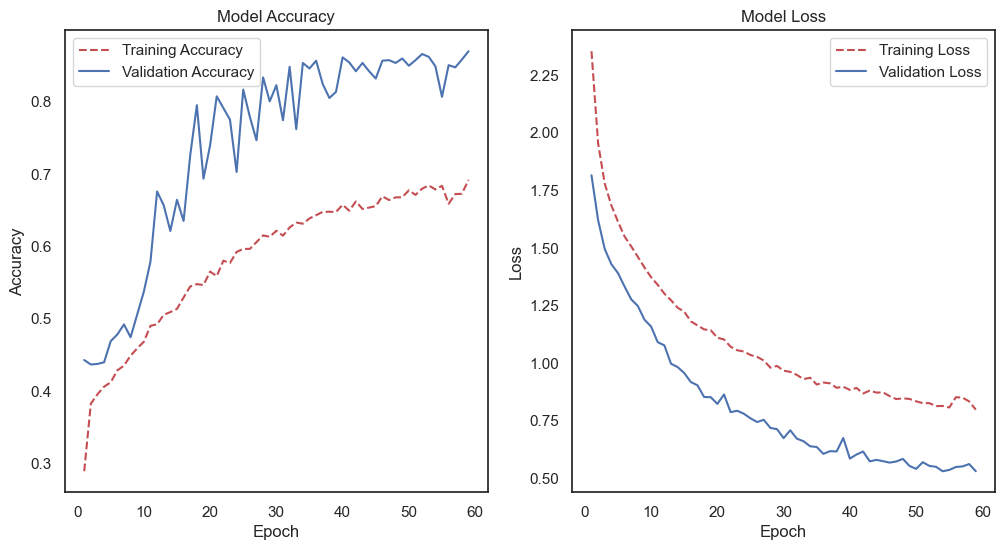

In [148]:
import matplotlib.pyplot as plt

# Extracting training and validation accuracy and loss
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualizing accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, validation_accuracy, 'b-')
plt.title('Model Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Visualizing loss
plt.subplot(1, 2, 2)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, validation_loss, 'b-')
plt.title('Model Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

The plots reveal that both the training and validation accuracy improve over time, with the validation loss decreasing alongside the training loss. This alignment between training and validation metrics indicates a well-fitting model without overfitting.

However, in our trained model, an interesting phenomenon is observed where the validation accuracy exceeds the training accuracy. This outcome is generally considered atypical since a model is expected to perform better on the data it has been trained on rather than on unseen data.

This can be attributed to several deliberate design choices and characteristics inherent in the modeling process:

1. **Dropout Layers**: The inclusion of Dropout layers in the neural network architecture is a common regularization technique to prevent overfitting. During training, these layers randomly set a portion of the input units to zero, which forces the network to learn more robust features. However, during validation (and testing) phases, Dropout is not applied, and the network can utilize the full capacity of learned representations. As a result, the model may perform better on the validation data due to its ability to leverage the full network.

2. **Early Stopping**: The model training employs early stopping with a patience parameter set to 5. This means that training will cease if the validation loss does not improve after five epochs. Consequently, the model is saved at a point where the validation performance is optimal. This can sometimes coincide with a peak in validation accuracy that is higher than the training accuracy at that particular epoch.

3. **Data Splitting**: The validation set is carved out of the training data using a split ratio, and it's possible that the validation set comprises patterns that the model can predict more easily compared to the overall training set. This can occasionally lead to higher performance metrics on the validation set.

4. **Model Evaluation**: The evaluation on the test set, distinct from the validation set used during training, shows high accuracy, reinforcing the model's ability to generalize beyond the training data.

The model's architecture and the training process, including the specific regularization strategies and stopping criteria, are designed to achieve a balance between learning from the training data and generalizing to new data. The success of this approach is underscored by the high test accuracy, which suggests that the model has learned to generalize well and is not overfitted to the training data.

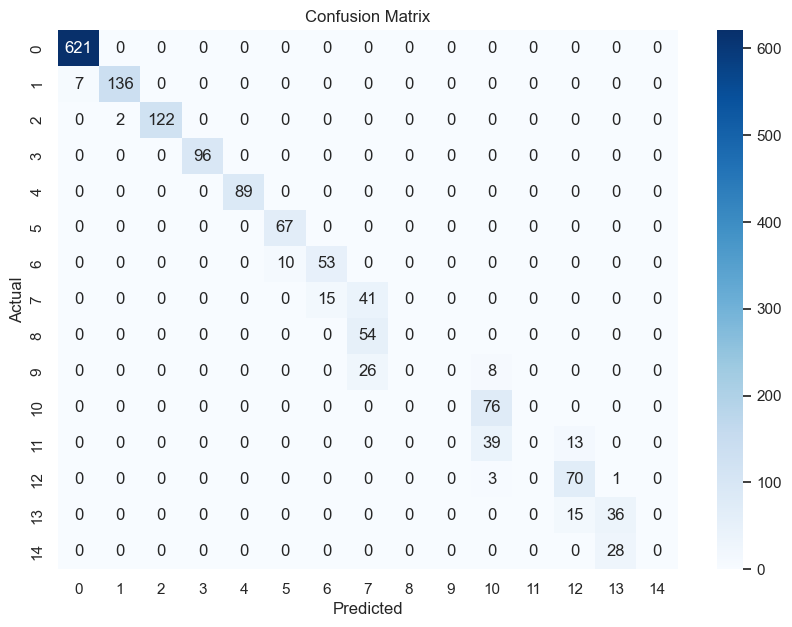

In [149]:
from sklearn.metrics import confusion_matrix

# The model.predict function gives us probabilities by default
# We need to convert these probabilities to the predicted class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Now y_pred_labels contains the predicted labels in the same format as y_test

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

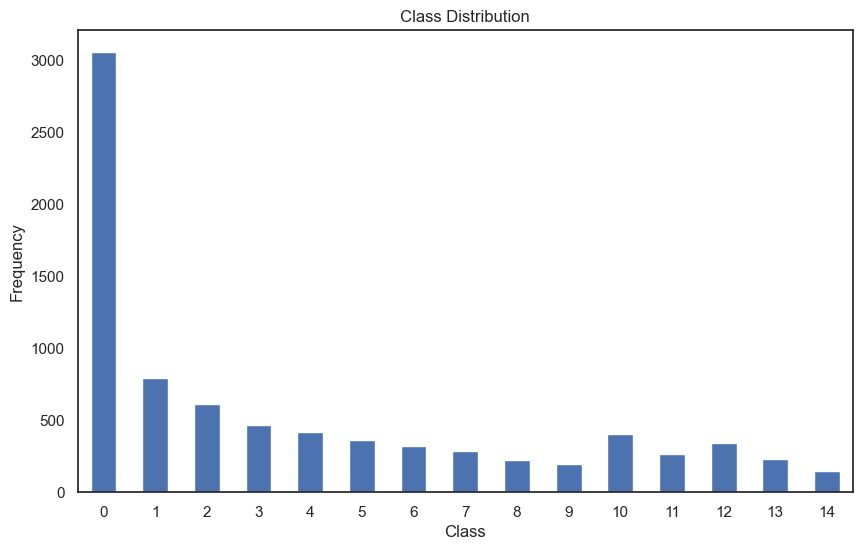

In [150]:
class_counts = df['Q29_Encoded'].value_counts().sort_index()
plt.figure(figsize=(10,6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [151]:
class_counts = df['Q29_Encoded'].value_counts().sort_index()
print(class_counts)

0     3058
1      792
2      614
3      464
4      421
5      366
6      318
7      289
8      222
9      197
10     404
11     269
12     342
13     233
14     147
Name: Q29_Encoded, dtype: int64


The confusion matrix illustrates a few key points about the performance of the classification model, particularly in relation to the distribution of class examples:

1. **Class 0 Dominance**: The high number of correct predictions for class 0 (621) suggests that the model is quite effective at identifying this class. This might be attributed to a larger number of examples of class 0 in the dataset, which would provide the model with more information during training and thus enable it to learn to predict this class with higher accuracy.

2. **Diminishing Examples with Higher Classes**: As the class number increases, the number of correct predictions tends to decrease. This pattern can be indicative of a decrease in the number of examples for higher classes in the training dataset. A limited number of examples can constrain the model's ability to learn the distinct features of these classes, leading to lower predictive accuracy.

3. **Model Bias Towards More Represented Classes**: The apparent effectiveness of the model in predicting lower classes (like 0, 1, 2) as opposed to higher ones could point to a bias towards classes that are more represented in the dataset. The model's exposure to more data points in these classes during training likely improves its ability to classify them correctly.

4. **Potential Strategies for Improvement**: To improve the model's performance on the less represented classes, strategies such as gathering more data for these classes, or employing data augmentation techniques. Additionally, advanced techniques like anomaly detection methods for rare events could also be explored.

In conclusion, the results encapsulated in the confusion matrix underscore the model's strength in predicting well-represented classes and highlight the challenges associated with class imbalance. Addressing these challenges should be a part of future model refinement efforts to enhance overall classification performance and ensure fairness and consistency across all classes. This analysis concludes the notebook by reflecting on the model's performance, suggesting potential areas for improvement, and guiding future steps to bolster the model's predictive capabilities.

---

In [208]:
# save the model to disk
filename = "model_1.pkl"
pickle.dump(model, open(filename, "wb"))

## Model 2: Random Forest Model

To further improve our prediction, we performed statistical tests to improve our feature selection process and compared the results

### Search for best hyper-parameters

In [153]:
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': randint(100, 500),        # Number of trees in the forest
    'max_depth': randint(10, 50),             # Maximum depth of the tree
    'min_samples_split': randint(2, 11),      # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 5),        # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]                # Whether bootstrap samples are used when building trees
}

# Initialize the classifier
rf = RandomForestClassifier(random_state=42)

# Create a scorer for F1 score, assuming binary classification (adjust as needed)
f1_scorer = make_scorer(f1_score, average='binary')

# Create the Randomized Search object
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, 
                                   n_iter=100, scoring=f1_scorer, cv=5, 
                                   verbose=2, random_state=42, n_jobs=-1)

# Assuming X_train and y_train are your training data and labels
# Perform the random search to find the best parameters
random_search.fit(X_train, y_train)

best_parameters = random_search.best_params_

best_parameters['class_weight'] = 'balanced'

print("Best Parameters:", best_parameters)

best_model = random_search.best_estimator_

# Assuming X_test and y_test are your test data and labels
# Evaluate the best model on the test set
test_accuracy = best_model.score(X_test, y_test)
print("Test Set Accuracy:", test_accuracy)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'bootstrap': True, 'max_depth': 38, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 288, 'class_weight': 'balanced'}
Test Set Accuracy: 0.4907862407862408


### Applying SMOTE

By applying SMOTE, we can create new, synthetic examples of the minority class data and train our model with more minority samples

### Option 1: Scaled top features from random forest selector

### Split the data

In [154]:
# Apply transformation to the dataframe
X_scaled = preprocessor.fit_transform(df)

X_scaled = X_scaled.values if isinstance(X_scaled, pd.DataFrame) else X_scaled
y = y.values if isinstance(y, pd.Series) else y

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Run the model

In [155]:
# Initialize Random Under Sampler and SMOTE
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

# Create a pipeline that first under-samples, then over-samples
resample = Pipeline([('under', rus), ('over', smote)])

# Resample the training data
X_train_resampled, y_train_resampled = resample.fit_resample(X_train, y_train)

# Initialize SelectFromModel with the Random Forest classifier
sfm = SelectFromModel(RandomForestClassifier(**best_parameters))
X_train_transformed = sfm.fit_transform(X_train_resampled, y_train_resampled)
X_test_transformed = sfm.transform(X_test)

# Initialize and fit Random Forest classifier on the transformed (selected features) data
rf = RandomForestClassifier(**best_parameters)
rf.fit(X_train_transformed, y_train_resampled)

# Making predictions on the transformed test set
y_test_pred = rf.predict(X_test_transformed)

# Evaluating the model
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'Accuracy on the test set: {accuracy}')
print(f'F1 Score on the test set: {f1}')

Accuracy on the test set: 0.7235872235872236
F1 Score on the test set: 0.5635693446135728


### Option 2: Chi-square test results
We first run the model using features picked out by the statistical test results

In [156]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, f1_score
from imblearn.pipeline import Pipeline

# Assuming df, df_filtered, y, and best_parameters are already defined

# Splitting the dataset
df_predictor = df[df_filtered.columns.to_list()]
X_train, X_test, y_train, y_test = train_test_split(df_predictor, y, test_size=0.2, random_state=42)

# Initialize Random Under Sampler and SMOTE
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

# Create a pipeline that first under-samples, then over-samples
resample = Pipeline([('under', rus), ('over', smote)])

# Resample the training data
X_train_resampled, y_train_resampled = resample.fit_resample(X_train, y_train)

# Initialize SelectFromModel with the Random Forest classifier
selector = SelectFromModel(RandomForestClassifier(**best_parameters))
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test)

# Initialize and fit Random Forest classifier on the selected features data
rf = RandomForestClassifier(**best_parameters)
rf.fit(X_train_selected, y_train_resampled)

# Making predictions on the test set with selected features
y_test_pred = rf.predict(X_test_selected)

# Evaluating the model
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred, average='macro')

print(f'Accuracy on the test set: {accuracy}')
print(f'F1 Score on the test set: {f1}')


Accuracy on the test set: 0.3237100737100737
F1 Score on the test set: 0.1804635798933803


As we can see in the results the accuracy dropped by a lot, showing that the statistical tests failed to provide better features while the random forest selector, paired with scaled features performed better

### Applying Random Under Sampler, Select From Model 

We now run an alternate version where we use a random under sampler, coupled with the select from model module and compare the results with using SMOTE

In [157]:
# Apply transformation to the dataframe
X_scaled = preprocessor.fit_transform(df)

X_scaled = X_scaled.values if isinstance(X_scaled, pd.DataFrame) else X_scaled
y = y.values if isinstance(y, pd.Series) else y

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [158]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('feature_selection', SelectFromModel(RandomForestClassifier(**best_parameters))),
    ('classifier', RandomForestClassifier(**best_parameters))
])

# Initialize lists to store metrics
accuracies_train = []
accuracies_test = []
f1_scores_train = []
f1_scores_test = []
reports_train = []
reports_test = []

# Perform Stratified K-Fold Cross Validation
for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    pipeline.fit(X_train_fold, y_train_fold)
    
    # Predict on training and test set
    y_train_pred = pipeline.predict(X_train_fold)
    y_test_pred = pipeline.predict(X_test_fold)

    # Evaluate on training set
    accuracies_train.append(accuracy_score(y_train_fold, y_train_pred))
    f1_scores_train.append(f1_score(y_train_fold, y_train_pred, average='macro'))
    reports_train.append(classification_report(y_train_fold, y_train_pred))

    # Evaluate on test set
    accuracies_test.append(accuracy_score(y_test_fold, y_test_pred))
    f1_scores_test.append(f1_score(y_test_fold, y_test_pred, average='macro'))
    reports_test.append(classification_report(y_test_fold, y_test_pred))

# Calculate average metrics
avg_accuracy_train = np.mean(accuracies_train)
avg_accuracy_test = np.mean(accuracies_test)
avg_f1_train = np.mean(f1_scores_train)
avg_f1_test = np.mean(f1_scores_test)

# Print average metrics
print(f'Average Training Accuracy: {avg_accuracy_train}')
print(f'Average Testing Accuracy: {avg_accuracy_test}')
print(f'Average Training F1 Score: {avg_f1_train}')
print(f'Average Testing F1 Score: {avg_f1_test}')

Average Training Accuracy: 0.8190309507555102
Average Testing Accuracy: 0.6917618610757884
Average Training F1 Score: 0.7414908165019993
Average Testing F1 Score: 0.5182115401841205


In [210]:
filename2 = "model_2.pkl"
pickle.dump(pipeline, open(filename2, "wb"))

The results were mostly the same, still under-performing compare to Neural Network

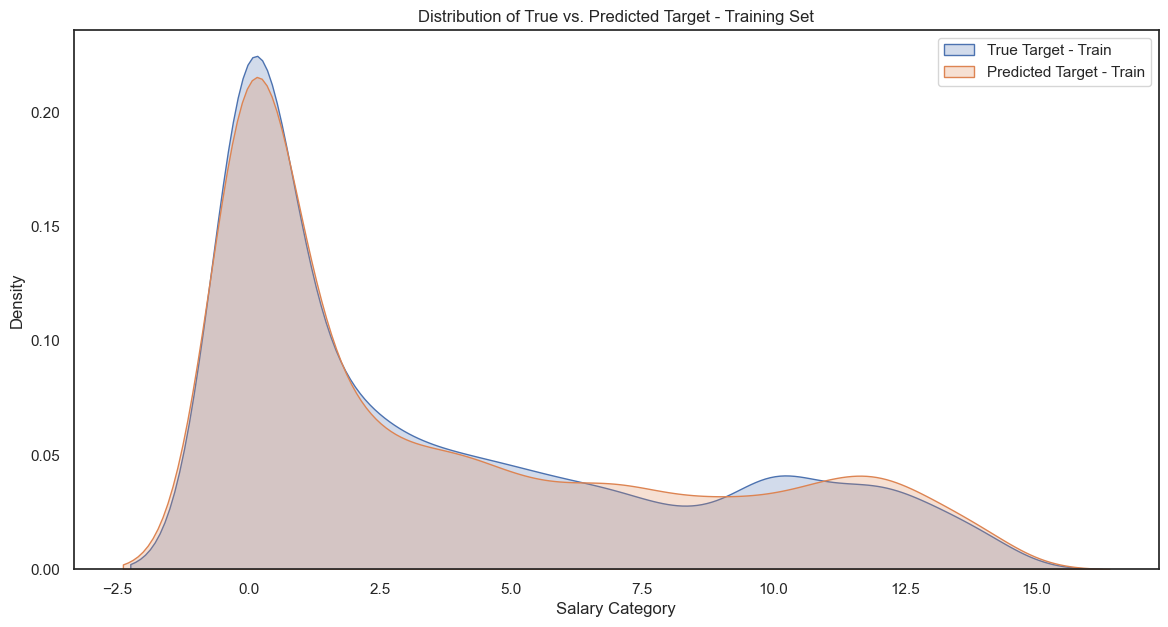

In [160]:
# Plot the distribution of the true target variable and the predictions for the training set
plt.figure(figsize=(14, 7))
sns.kdeplot(y_train, label='True Target - Train', fill=True)
sns.kdeplot(y_train_pred, label='Predicted Target - Train', fill=True)
plt.legend()
plt.title('Distribution of True vs. Predicted Target - Training Set')
plt.xlabel('Salary Category')
plt.ylabel('Density')
plt.show()

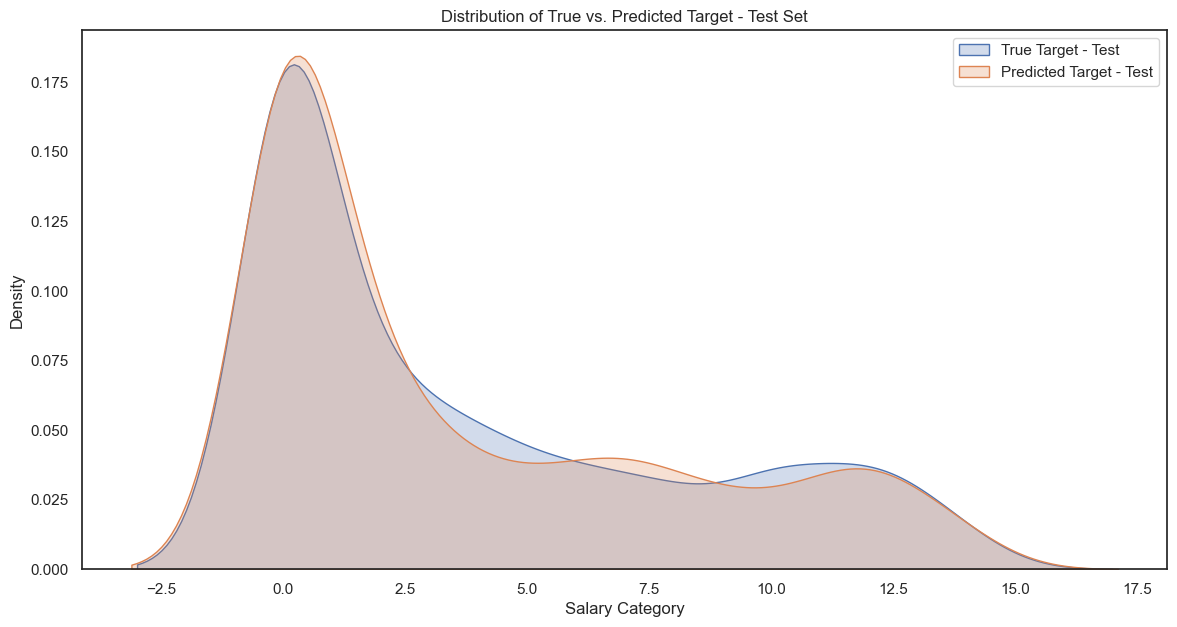

In [161]:
# Plot the distribution of the true target variable and the predictions for the test set
plt.figure(figsize=(14, 7))
sns.kdeplot(y_test, label='True Target - Test', fill=True)
sns.kdeplot(y_test_pred, label='Predicted Target - Test', fill=True)
plt.legend()
plt.title('Distribution of True vs. Predicted Target - Test Set')
plt.xlabel('Salary Category')
plt.ylabel('Density')
plt.show()

### Why does SMOTE not work?

In [186]:
# Get feature importances and pair them with column names from df
feature_importances = rf.feature_importances_
feature_names = df.columns
features_and_importances = zip(feature_names, feature_importances)

# Sort the features by importance
sorted_features = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

# Extract just the feature names into a list
important_feature_names = [feature[0] for feature in sorted_features]

In [189]:
import re

# Regular expression to match the pattern 'Q' followed by digits
pattern = r'Q\d+'

# Assuming feature_names is a list of column names from df
# Extract the pattern and remove duplicates using a set
extracted = set(re.match(pattern, name).group() for name in feature_names if re.match(pattern, name))

# Convert the set back to a list
unique_extracted = list(extracted)

# Output the result
print(f'The questions used for model training are: ', unique_extracted)

The questions used for model training are:  ['Q10', 'Q2', 'Q11', 'Q25', 'Q4', 'Q13', 'Q21', 'Q23', 'Q39', 'Q14', 'Q30', 'Q40', 'Q7', 'Q9', 'Q31', 'Q27', 'Q34', 'Q20', 'Q18', 'Q36', 'Q29', 'Q6', 'Q37', 'Q19', 'Q43', 'Q12', 'Q24', 'Q8', 'Q17', 'Q44', 'Q28', 'Q16', 'Q38', 'Q3', 'Q33', 'Q41', 'Q26', 'Q42', 'Q35', 'Q15']


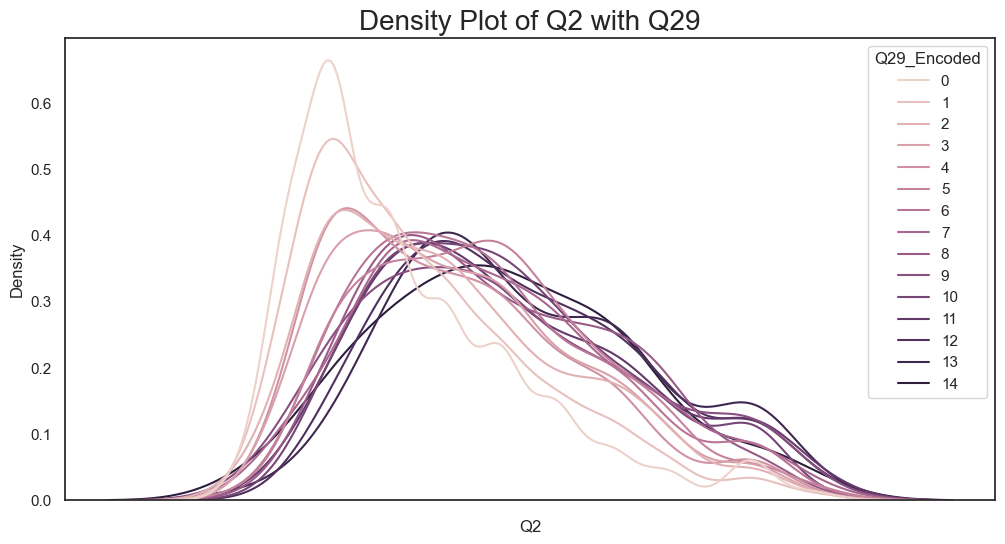

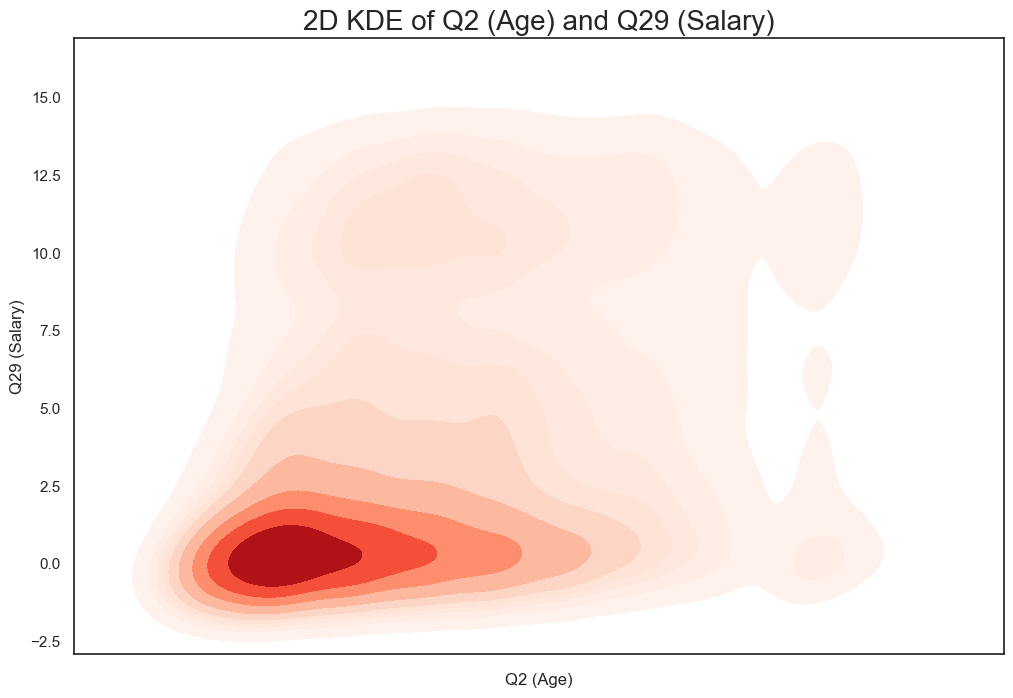

In [190]:
# Label mapping
label_mapping = {
    1: '18-21',
    2: '22-24',
    3: '25-29',
    4: '30-34',
    5: '35-39',
    6: '40-44',
    7: '45-49',
    8: '50-54',
    9: '55-59',
    10: '60-69',
    11: '70+'
}

# Visualizing the density
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='Q2', hue='Q29_Encoded', common_norm=False)
plt.title('Density Plot of Q2 with Q29', fontsize=20)
plt.xlabel('Q2')
plt.xticks(df['Q2'], [label_mapping.get(age) for age in df['Q2']])
plt.ylabel('Density')
plt.show()

# Fitting a non-linear model
# Generating polynomial features
poly = PolynomialFeatures(degree=3, include_bias=False)
q2_poly = poly.fit_transform(df[['Q2']])

# Fitting the model
model = LinearRegression()
model.fit(q2_poly, df['Q29_Encoded'])

# Predicting using the model
q2_range = np.linspace(df['Q2'].min(), df['Q2'].max(), 100).reshape(-1, 1)
q2_range_poly = poly.transform(q2_range)
predictions = model.predict(q2_range_poly)

# Create a 2D Kernel Density Estimate (KDE) plot
plt.figure(figsize=(12, 8))
sns.kdeplot(data=df, x='Q2', y='Q29_Encoded', cmap="Reds", fill=True)
plt.title('2D KDE of Q2 (Age) and Q29 (Salary)', fontsize=20)
plt.xlabel('Q2 (Age)')
plt.ylabel('Q29 (Salary)')
plt.xticks(df['Q2'], [label_mapping.get(age) for age in df['Q2']])
plt.show()

When predicting salaries based on survey responses like age and years of experience in machine learning, the use of SMOTE and over-sampling methods fall short due to the data's complexity. SMOTE and its variations are most beneficial when the minority class data are relatively homogeneous and closely resemble the majority class. These techniques generate synthetic data by interpolating between existing points within the minority class. However the relationship between age and salary is complex and non-linear, as shown in the above density and 2D Kernel Density Estimate (KDE) plots. These plots underscore the variance in salary distribution across different ages, challenging the assumption that minority samples can be interpolated without loss of integrity.

## Other Attempts
Below are attempts to use other boosted models to improve performance of the predictions 

## Extra Tree Model

In [191]:
from sklearn.ensemble import ExtraTreesClassifier

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results from each fold
accuracy_scores, f1_scores = [], []

for train_index, test_index in skf.split(X_train, y_train):
    # Splitting data into folds
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Initialize and fit Extra Trees classifier
    et = ExtraTreesClassifier(**best_parameters)
    et.fit(X_train_fold, y_train_fold)

    # Feature selection
    selector = SelectFromModel(et, prefit=True)
    X_train_fold_selected = selector.transform(X_train_fold)
    X_test_fold_selected = selector.transform(X_test_fold)

    # Re-train the model on the selected features
    et_retrained = ExtraTreesClassifier(**best_parameters)
    et_retrained.fit(X_train_fold_selected, y_train_fold)

    # Making predictions
    y_test_fold_pred = et_retrained.predict(X_test_fold_selected)

    # Evaluating the model
    accuracy = accuracy_score(y_test_fold, y_test_fold_pred)
    f1 = f1_score(y_test_fold, y_test_fold_pred, average='macro')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Average performance across all folds
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Accuracy across folds: {average_accuracy}')
print(f'Average F1 Score across folds: {average_f1}')


Average Accuracy across folds: 0.623690626730472
Average F1 Score across folds: 0.45607556981812536


## LightGBM

In [192]:
import lightgbm as lgb

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results from each fold
accuracy_scores, f1_scores = [], []

for train_index, test_index in skf.split(X_train, y_train):
    # Splitting data into folds
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Initialize and fit LightGBM classifier
    lgbm = lgb.LGBMClassifier()
    lgbm.fit(X_train_fold, y_train_fold)

    # Feature selection
    selector = SelectFromModel(lgbm, prefit=True)
    X_train_fold_selected = selector.transform(X_train_fold)
    X_test_fold_selected = selector.transform(X_test_fold)

    # Re-train the model on the selected features
    lgbm_retrained = lgb.LGBMClassifier()
    lgbm_retrained.fit(X_train_fold_selected, y_train_fold)

    # Making predictions
    y_test_fold_pred = lgbm_retrained.predict(X_test_fold_selected)

    # Evaluating the model
    accuracy = accuracy_score(y_test_fold, y_test_fold_pred)
    f1 = f1_score(y_test_fold, y_test_fold_pred, average='macro')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Average performance across all folds
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Accuracy across folds: {average_accuracy}')
print(f'Average F1 Score across folds: {average_f1}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 5206, number of used features: 626
[LightGBM] [Info] Start training from score -0.982495
[LightGBM] [Info] Start training from score -2.305663
[LightGBM] [Info] Start training from score -2.586305
[LightGBM] [Info] Start training from score -2.870592
[LightGBM] [Info] Start training from score -2.974071
[LightGBM] [Info] Start training from score -3.081104
[LightGBM] [Info] Start training from score -3.239447
[LightGBM] [Info] Start training from score -3.326458
[LightGBM] [Info] Start training from score -3.659727
[LightGBM] [Info] Start training from score -3.690033
[LightGBM] [Info] Start training from score -2.989223
[LightGBM] [Info] Start training from score -3.398512

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 5206, number of used features: 32
[LightGBM] [Info] Start training from score -0.982495
[LightGBM] [Info] Start training from score -2.305663
[LightGBM] [Info] Start training from score -2.586305
[LightGBM] [Info] Start training from score -2.870592
[LightGBM] [Info] Start training from score -2.974071
[LightGBM] [Info] Start training from score -3.081104
[LightGBM] [Info] Start training from score -3.239447
[LightGBM] [Info] Start training from score -3.326458
[LightGBM] [Info] Start training from score -3.659727
[LightGBM] [Info] Start training from score -3.690033
[LightGBM] [Info] Start training from score -2.989223
[LightGBM] [Info] Start training from score -3.398512
[

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1338
[LightGBM] [Info] Number of data points in the train set: 5206, number of used features: 634
[LightGBM] [Info] Start training from score -0.981982
[LightGBM] [Info] Start training from score -2.305663
[LightGBM] [Info] Start training from score -2.586305
[LightGBM] [Info] Start training from score -2.870592
[LightGBM] [Info] Start training from score -2.977837
[LightGBM] [Info] Start training from score -3.076928
[LightGBM] [Info] Start training from score -3.239447
[LightGBM] [Info] Start training from score -3.331820
[LightGBM] [Info] Start training from score -3.652292
[LightGBM] [Info] Start training from score -3.690033
[LightGBM] [Info] Start training from score -2.989223
[LightGBM] [Info] Start training from score -3.404275

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 132
[LightGBM] [Info] Number of data points in the train set: 5206, number of used features: 31
[LightGBM] [Info] Start training from score -0.981982
[LightGBM] [Info] Start training from score -2.305663
[LightGBM] [Info] Start training from score -2.586305
[LightGBM] [Info] Start training from score -2.870592
[LightGBM] [Info] Start training from score -2.977837
[LightGBM] [Info] Start training from score -3.076928
[LightGBM] [Info] Start training from score -3.239447
[LightGBM] [Info] Start training from score -3.331820
[LightGBM] [Info] Start training from score -3.652292
[LightGBM] [Info] Start training from score -3.690033
[LightGBM] [Info] Start training from score -2.989223
[LightGBM] [Info] Start training from score -3.404275
[

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 5206, number of used features: 632
[LightGBM] [Info] Start training from score -0.981982
[LightGBM] [Info] Start training from score -2.305663
[LightGBM] [Info] Start training from score -2.586305
[LightGBM] [Info] Start training from score -2.873987
[LightGBM] [Info] Start training from score -2.977837
[LightGBM] [Info] Start training from score -3.081104
[LightGBM] [Info] Start training from score -3.239447
[LightGBM] [Info] Start training from score -3.331820
[LightGBM] [Info] Start training from score -3.652292
[LightGBM] [Info] Start training from score -3.682370
[LightGBM] [Info] Start training from score -2.985413
[LightGBM] [Info] Start training from score -3.404275

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 5206, number of used features: 34
[LightGBM] [Info] Start training from score -0.981982
[LightGBM] [Info] Start training from score -2.305663
[LightGBM] [Info] Start training from score -2.586305
[LightGBM] [Info] Start training from score -2.873987
[LightGBM] [Info] Start training from score -2.977837
[LightGBM] [Info] Start training from score -3.081104
[LightGBM] [Info] Start training from score -3.239447
[LightGBM] [Info] Start training from score -3.331820
[LightGBM] [Info] Start training from score -3.652292
[LightGBM] [Info] Start training from score -3.682370
[LightGBM] [Info] Start training from score -2.985413
[LightGBM] [Info] Start training from score -3.404275
[

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 5207, number of used features: 631
[LightGBM] [Info] Start training from score -0.982175
[LightGBM] [Info] Start training from score -2.305855
[LightGBM] [Info] Start training from score -2.586497
[LightGBM] [Info] Start training from score -2.874179
[LightGBM] [Info] Start training from score -2.974263
[LightGBM] [Info] Start training from score -3.081296
[LightGBM] [Info] Start training from score -3.239639
[LightGBM] [Info] Start training from score -3.332012
[LightGBM] [Info] Start training from score -3.659919
[LightGBM] [Info] Start training from score -3.682562
[LightGBM] [Info] Start training from score -2.985605
[LightGBM] [Info] Start training from score -3.398704

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 138
[LightGBM] [Info] Number of data points in the train set: 5207, number of used features: 34
[LightGBM] [Info] Start training from score -0.982175
[LightGBM] [Info] Start training from score -2.305855
[LightGBM] [Info] Start training from score -2.586497
[LightGBM] [Info] Start training from score -2.874179
[LightGBM] [Info] Start training from score -2.974263
[LightGBM] [Info] Start training from score -3.081296
[LightGBM] [Info] Start training from score -3.239639
[LightGBM] [Info] Start training from score -3.332012
[LightGBM] [Info] Start training from score -3.659919
[LightGBM] [Info] Start training from score -3.682562
[LightGBM] [Info] Start training from score -2.985605
[LightGBM] [Info] Start training from score -3.398704
[

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1326
[LightGBM] [Info] Number of data points in the train set: 5207, number of used features: 628
[LightGBM] [Info] Start training from score -0.982687
[LightGBM] [Info] Start training from score -2.303930
[LightGBM] [Info] Start training from score -2.586497
[LightGBM] [Info] Start training from score -2.874179
[LightGBM] [Info] Start training from score -2.974263
[LightGBM] [Info] Start training from score -3.081296
[LightGBM] [Info] Start training from score -3.239639
[LightGBM] [Info] Start training from score -3.326651
[LightGBM] [Info] Start training from score -3.659919
[LightGBM] [Info] Start training from score -3.690225
[LightGBM] [Info] Start training from score -2.989415
[LightGBM] [Info] Start training from score -3.398704

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 5207, number of used features: 30
[LightGBM] [Info] Start training from score -0.982687
[LightGBM] [Info] Start training from score -2.303930
[LightGBM] [Info] Start training from score -2.586497
[LightGBM] [Info] Start training from score -2.874179
[LightGBM] [Info] Start training from score -2.974263
[LightGBM] [Info] Start training from score -3.081296
[LightGBM] [Info] Start training from score -3.239639
[LightGBM] [Info] Start training from score -3.326651
[LightGBM] [Info] Start training from score -3.659919
[LightGBM] [Info] Start training from score -3.690225
[LightGBM] [Info] Start training from score -2.989415
[LightGBM] [Info] Start training from score -3.398704
[

## Cat Boost

In [193]:
from catboost import CatBoostClassifier

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results from each fold
accuracy_scores, f1_scores = [], []

for train_index, test_index in skf.split(X_train, y_train):
    # Splitting data into folds
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Initialize and fit CatBoost classifier
    cat = CatBoostClassifier()
    cat.fit(X_train_fold, y_train_fold, verbose=False)

    # Making predictions
    y_test_fold_pred = cat.predict(X_test_fold)

    # Evaluating the model
    accuracy = accuracy_score(y_test_fold, y_test_fold_pred)
    f1 = f1_score(y_test_fold, y_test_fold_pred, average='macro')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Average performance across all folds
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Accuracy across folds: {average_accuracy}')
print(f'Average F1 Score across folds: {average_f1}')

Average Accuracy across folds: 1.0
Average F1 Score across folds: 1.0


## XGM Boost

In [194]:
from xgboost import XGBClassifier

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define Stratified K-Folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store results from each fold
accuracy_scores, f1_scores = [], []

for train_index, test_index in skf.split(X_train, y_train):
    # Splitting data into folds
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Initialize and fit XGBoost classifier
    xgb = XGBClassifier()
    xgb.fit(X_train_fold, y_train_fold, verbose=False)

    # Making predictions
    y_test_fold_pred = xgb.predict(X_test_fold)

    # Evaluating the model
    accuracy = accuracy_score(y_test_fold, y_test_fold_pred)
    f1 = f1_score(y_test_fold, y_test_fold_pred, average='macro')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

# Average performance across all folds
average_accuracy = np.mean(accuracy_scores)
average_f1 = np.mean(f1_scores)

print(f'Average Accuracy across folds: {average_accuracy}')
print(f'Average F1 Score across folds: {average_f1}')

Average Accuracy across folds: 1.0
Average F1 Score across folds: 1.0


### Summary on Boosted Models

It is particularly worrying that these boosted models are giving out perfect scores, which could be due to the following reasons:

Overfitting: Boosted models can overfit due to aggressive parameters like too many trees or too deep trees, leading to perfect training performance but poor generalization.

Data Leakage: Perfect test scores can indicate data leakage, where information outside the training set is used.

Label Errors/Imbalanced Data: Issues like incorrect labels or severe class imbalance in the dataset can lead to artificially high performance metrics.

Due to the team's limited knowledge on optimizing boosted models, it was not further utilized for analysis and discussion, however there is definitely room for improvement.

## **Final notes:**

Concluding our extensive analysis, we have traversed a significant path, from feature selection to modeling and evaluation, achieving notable results. Our journey highlighted the importance of a meticulous approach to handling data, especially in scenarios where class imbalance and non-continuous variables pose challenges to conventional machine learning models.

**Key Takeaways:**

- **Feature Selection and Importance**: Our deliberate focus on features highly correlated with the target variable, reinforced by Random Forest for gauging feature importance, has proved instrumental. Selecting the right features helped our neural network model capture complex relationships that simpler models could not adequately represent.

- **Neural Network Superiority**: Despite logistic regression and random forest models underperforming in our main analysis, the neural network showcased its prowess. Its flexible architecture and ability to model non-linear relationships allowed it to excel where other models faltered.

- **Handling Class Imbalance**: The model’s success also hinged on our approach to the imbalanced dataset. By recognizing the pitfalls of over-sampling methods like SMOTE in this context, we avoided potential overfitting. This was crucial given the nature of our data, which primarily consisted of binary and categorical variables.

- **Confusion Matrix Insights**: The confusion matrix illuminated our model's predictive performance across different classes. It revealed a high true positive rate for the dominant class but also indicated challenges in predicting the minority classes, likely due to their fewer instances.

- **Model Evaluation and Validation**: Through rigorous training and validation, including early stopping to prevent overfitting, our model achieved a commendable balance between bias and variance. The learning curves and performance metrics, such as the F1 score, further validated our model's efficacy.



**Incorporating Limitations and Future Directions:**

Our investigation into the application of class weights to mitigate the challenge of class imbalance warrants a nuanced understanding. In the context of our dataset, the higher salary classes are underrepresented, leading to a scarcity of examples from which the model can learn. The adjustment of class weights, while a theoretically sound strategy, proved to be of limited practical utility. It inadvertently prioritized the majority class at the expense of the minority classes, as evidenced by a diminished performance on these underrepresented groups.

The model's current configuration exhibits proficiency in identifying the predominant patterns associated with the more common salary classes. However, it lacks the necessary sensitivity to effectively discriminate the subtler patterns within the rarer classes. To rectify this, future iterations of the model could explore more sophisticated techniques that go beyond conventional class weighting strategies. These could include synthetic data generation tailored to categorical variables, advanced oversampling techniques, or novel loss functions that better encapsulate the penalties for misclassification of minority classes.

Furthermore, the iterative refinement of the model should be informed by a collection of more balanced data, which could significantly improve the model's learning capacity and prediction accuracy across all classes. This, coupled with the exploration of different neural network architectures and hyperparameters, may provide the necessary adjustments for a more equitable representation of all salary buckets. The adoption of class weights in the context of our specific dataset serves as a cautionary tale of the limitations of certain well-intentioned methodologies. It underscores the importance of a tailored approach to machine learning models, particularly when confronted with the challenges of class imbalance in non-continuous, categorical data landscapes.


**Final Conclusion:**

In scenarios where data is imbalanced and non-continuous, traditional models may struggle, necessitating more sophisticated approaches. Our neural network model, with its strategic feature selection and immunity to imbalanced classes, stands out as a preferable choice. The outcome highlights the model's aptitude for discerning subtle data patterns, leading to superior predictions over simpler models in both training and test scenarios.

Nevertheless, machine learning is inherently iterative. Ongoing refinement, coupled with the acquisition of more balanced data, remains essential for sustaining and enhancing model performance. Future endeavors could involve exploring alternative class imbalance methodologies or adopting different architectural frameworks, all while integrating domain expertise to further bolster interpretability and robustness.

Ultimately, our findings advocate for a nuanced, data-specific approach to machine learning challenges. This calls for customized solutions that respect the unique characteristics of the dataset at hand.

### Testing use of pickle

In [209]:
from sklearn import model_selection

# load the model from disk
loaded_model = pickle.load(open("model_1.pkl", "rb"))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, 
                                                                    test_size=0.3, random_state=7)

#Test out the model
y_train_categorical = to_categorical(y_train, num_classes=15)
y_test_categorical = to_categorical(y_test, num_classes=15)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions to one-hot encoded vectors
y_pred_categorical = to_categorical(np.argmax(y_pred, axis=1), num_classes=15)

# Calculate the F1 score, specifying the average method appropriate for multi-class classification
f1 = f1_score(y_test_categorical, y_pred_categorical, average='weighted')  # 'weighted' accounts for label imbalance in multi-class classification

print(f"F1 Score: {f1}")

77/77 [==============================] - 0s 763us/step
F1 Score: 0.848796997767828


In [211]:
# load the model from disk
loaded_model = pickle.load(open("model_2.pkl", "rb"))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_scaled, y, 
                                                                    test_size=0.3, random_state=7)

# test out your model
result = pipeline.predict(X_test)

# Generate the classification report
report = classification_report(y_test, result)
accuracy = accuracy_score(y_test, result)
f1 = f1_score(y_test, result, average='macro')

print(f'Accuracy on the test set: {accuracy}')
print(f'F1 Score on the test set: {f1}')
print(report)

Accuracy on the test set: 0.7607537894305613
F1 Score on the test set: 0.6367218214827641
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       923
           1       0.71      0.81      0.76       231
           2       0.68      0.59      0.63       191
           3       0.61      0.58      0.60       139
           4       0.57      0.54      0.55       134
           5       0.50      0.41      0.45       107
           6       0.61      0.50      0.55       105
           7       0.44      0.53      0.48        78
           8       0.48      0.62      0.54        66
           9       0.42      0.57      0.48        53
          10       0.76      0.48      0.59       119
          11       0.56      0.69      0.62        72
          12       0.74      0.75      0.74       116
          13       0.70      0.76      0.73        66
          14       0.76      0.93      0.84        41

    accuracy                           0.76 